In [1]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM, SSMCMain.ModifiedMiCRM.SpaceMMiCRM, MLSolver

In [2]:
using CairoMakie, ProgressLogging
using Base.Threads
using BenchmarkTools

# Basic Cosmo

## Basic no space solve

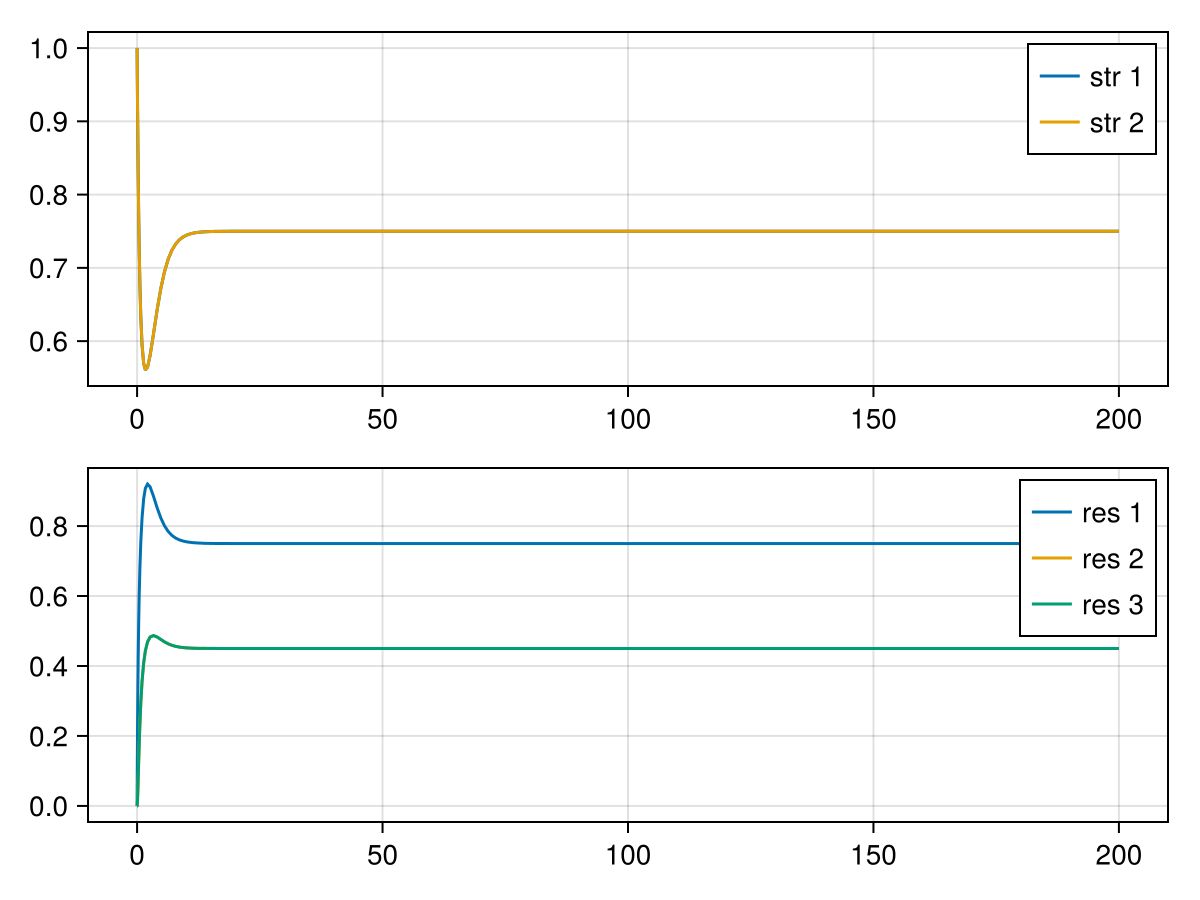

5-element Vector{Float64}:
 0.7499999950837934
 0.7499999950837934
 0.7500000042496404
 0.45000000174241855
 0.45000000174241855

In [3]:
D = fill(0., 2, 3, 3)
D[1,:,:] .= [0. 0. 0.; 0. 0. 0.; 1 0. 0.]
D[2,:,:] .= [0. 0. 0.; 1. 0. 0.; 0. 0. 0.]
p = make_mmicrm_smart(2, 3, 200;
    D=SArray{Tuple{2,3,3}}(D),
    K=[3., 0., 0.],
    r=[1., 1., 1.],
    l=[1. 0. 0.; 1. 0. 0.],
    c=[2. 2. 0.; 2. 0. 2.],
    m=[0.9, 0.9],
    u0=[1., 1., 0., 0., 0.],
    u0rand=0.
)
s = solve(p)
display(plot_mmicrm_sol(s))
s[end]
#param_summary(p.p)

#### Steady state solving

In [11]:
symsol = symbolic_solve_ode_ml(p)

┌ Warning: Solve::ratnz: Solve was unable to solve the system with inexact coefficients.
│     The answer was obtained by solving a corresponding exact system and
│     numericizing the result.
└ @ MathLink ~/.julia/packages/MathLink/S39uA/src/eval.jl:16


3-element Vector{Vector{Pair{Symbolics.Num, Symbolics.Num}}}:
 [u1 => 0.75, u2 => 0.75, u3 => 0.75, u4 => 0.45, u5 => 0.45]
 [u1 => 0.16666666666666666, u2 => 0.16666666666666666, u3 => 1.8, u4 => 0.45, u5 => 0.45]
 [u1 => 0.0, u2 => 0.0, u3 => 3.0, u4 => 0.0, u5 => 0.0]

In [16]:
sssol = solve(SteadyStateProblem(p), DynamicSS())
show(sssol)

[0.7499991588608942, 0.7499991588608942, 0.7500007386390256, 0.4500002918297526, 0.4500002918297526]

## Linear stability analysis

In [4]:
ks = LinRange(0., 10., 10000)
Ds = [0.01, 0.01, 1e2, 1., 1.]
usol = s.u[end]
#usol = sssol.u
#usol = Symbolics.value.(getindex.(symsol[2], 2))
show(uninplace(mmicrmfunc!)(usol, p.p, 0))

[2.613627797042001e-9, 2.613627797042001e-9, -2.2499420104793444e-9, -9.313096960283929e-10, -9.313096960283929e-10]

maximum(real(lambdas)) = 0.23503411881277064


[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 1.427410
[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 1.427410


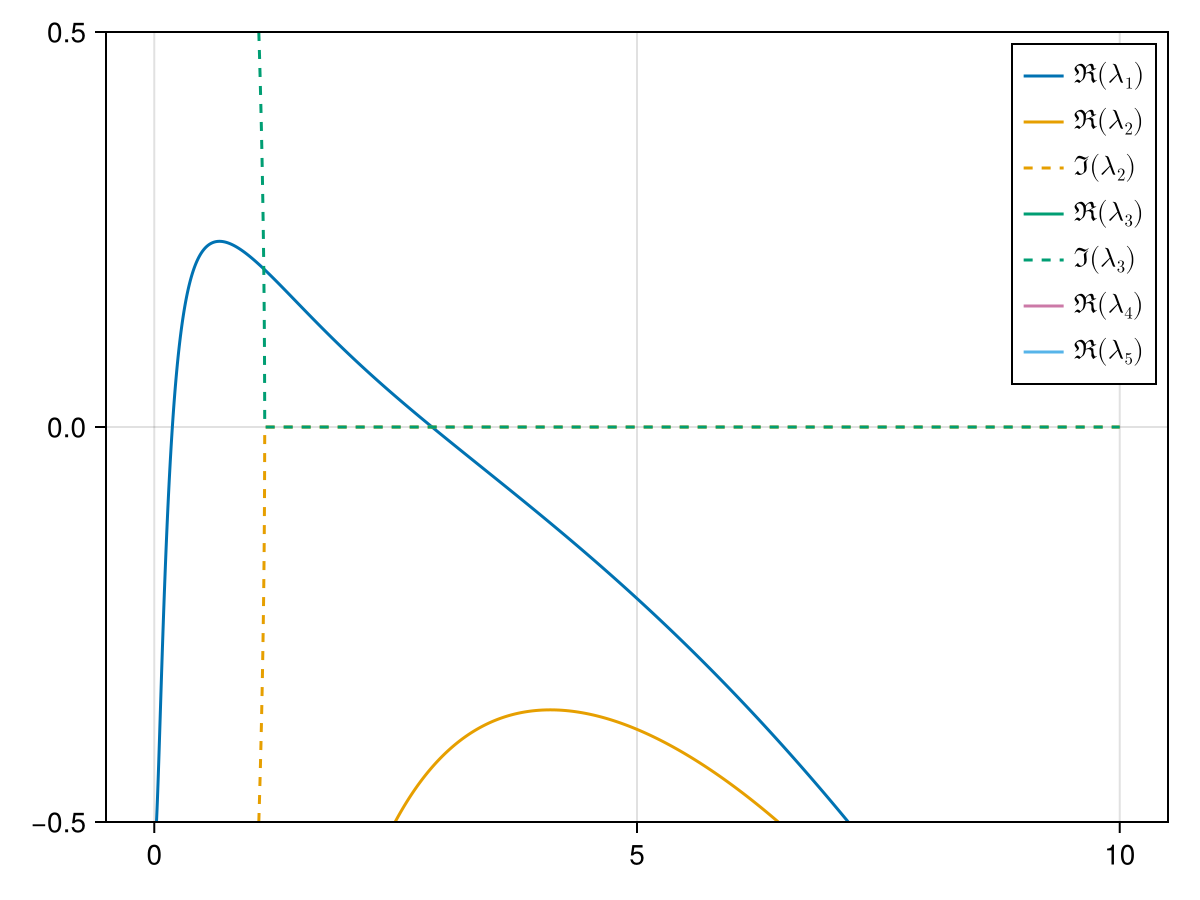

In [5]:
lambdas = do_linstab_for_ks(ks, p, Ds, usol);
@show maximum(real(lambdas))
faa = plot_linstab_lambdas(ks, lambdas[:,:])
ylims!(faa.axis, (-0.5, 0.5))
#xlims!(faa.axis, (0., 2.))
faa

In [6]:
# Finds the k with the biggest maximum eigenvalue
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
kmax_i, kmax

(676, 0.6750675067506751)

In [7]:
ff = linstab_make_full_func(p.p, usol, Ds)
kmax_es = ff(kmax)
kmax_es.vectors[:,1] # the eigensystem is sorted by evalue so this is the one

5-element Vector{ComplexF64}:
   0.6976388793421477 + 0.0im
   0.6976388793421481 + 0.0im
 -0.04202082925366469 + 0.0im
   0.1114321272553347 + 0.0im
  0.11143212725533479 + 0.0im

## Spatial stuff - 1D!

In [86]:
ssize = (4000,)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.1, 0.1)
space = make_cartesianspace_smart(length(ssize); dx=0.05, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 10000, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((5, 4000), 18, CartesianSpace{1, Tuple{Periodic}, Float64}([0.05]))

#### Direct solver

  6.840486 seconds (467.88 k allocations: 1.452 GiB, 4.31% gc time)


ReturnCode.Success = 1

941

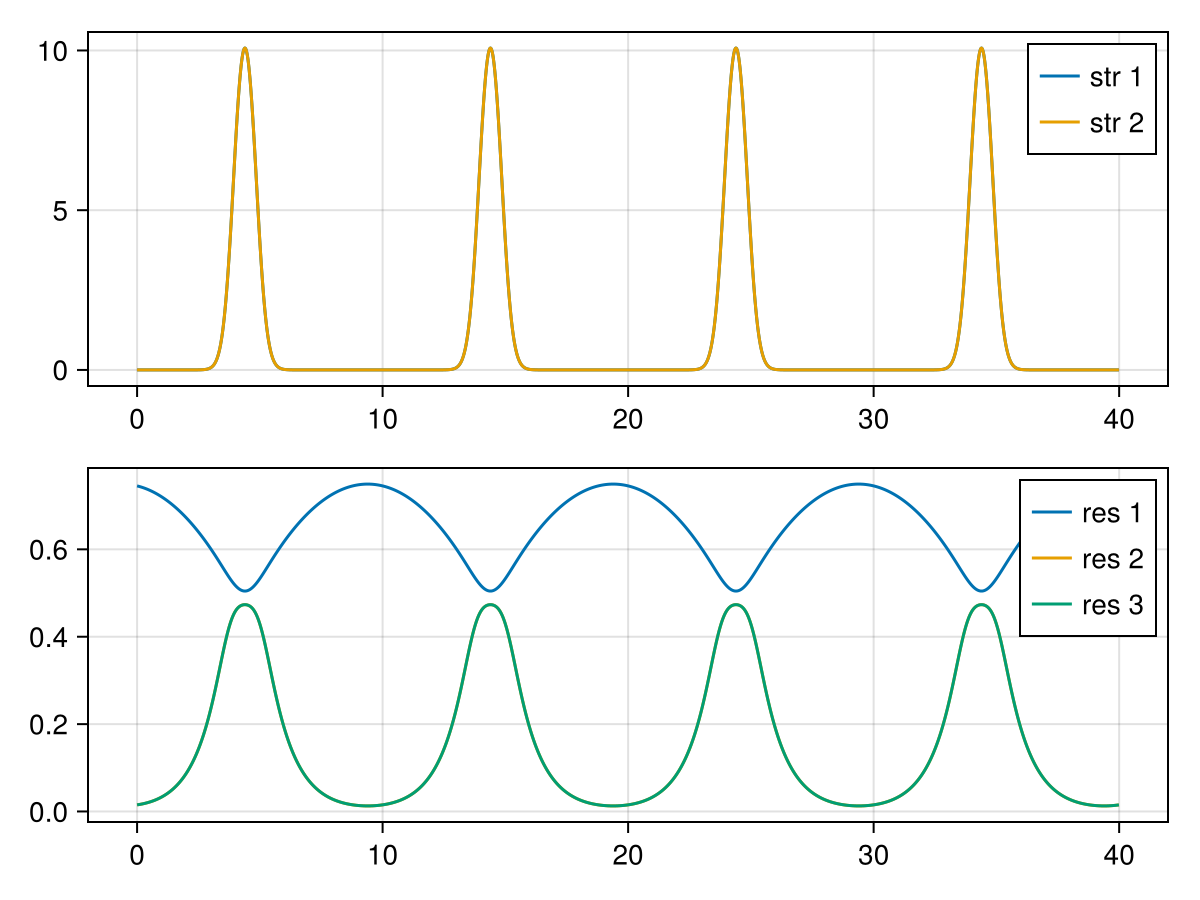

In [83]:
@time sps = solve(sp, QNDF(); maxiters=1000)
display(sps.retcode)
display(sps.destats.nf)
#display(plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end-1]))
plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

In [84]:
sps.stats

SciMLBase.DEStats
Number of function 1 evaluations:                  941
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    69
Number of linear solves:                           573
Number of Jacobians created:                       13
Number of nonlinear solver iterations:             456
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          196
Number of rejected steps:                          6

#### Steady state solver

 12.204321 seconds (836.84 k allocations: 2.199 GiB, 1.90% gc time)


ReturnCode.Success = 1

2803

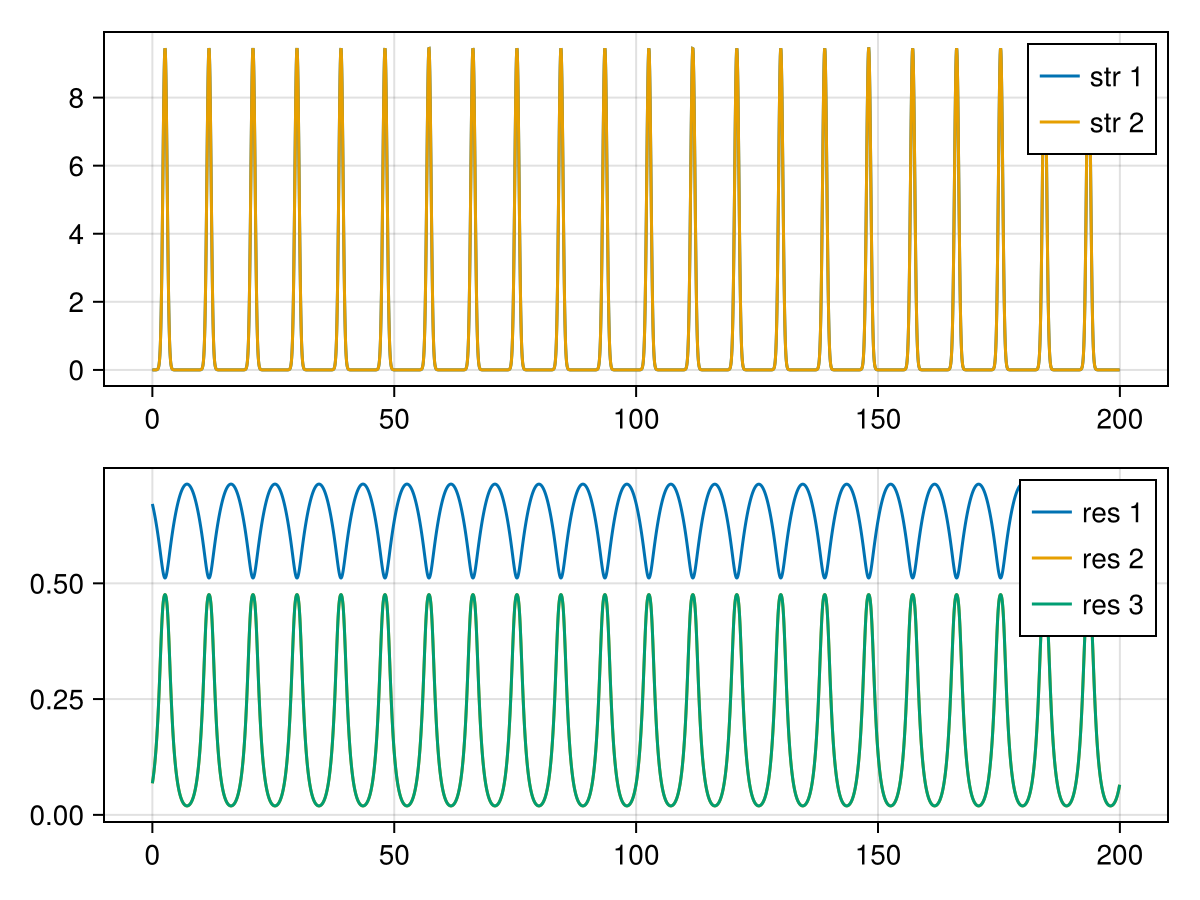

In [87]:
sssp = SteadyStateProblem(sp)
@time sssps = solve(sssp, DynamicSS(QNDF()); maxiters=1000)
display(sssps.retcode)
display(sssps.original.destats.nf)
plot_1dsmmicrm_sol_snap(sssps.prob.p, sssps.u)

## Spatial stuff - 2D!

In [288]:
ssize = (70,70)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.01, 0.01)
space = make_cartesianspace_smart(length(ssize); dx=0.3, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 100000, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((5, 70, 70), 18, CartesianSpace{2, Tuple{Periodic, Periodic}, Float64}([0.3, 0.3]))

#### Direct solver

In [289]:
@time sps = solve(sp, QNDF(); maxiters=1000)
display(sps.retcode)
display(sps.destats.nf)
#display(plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end-1]))
#plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

 81.901260 seconds (717.11 k allocations: 9.594 GiB, 1.70% gc time, 0.00% compilation time)


ReturnCode.Success = 1

2196

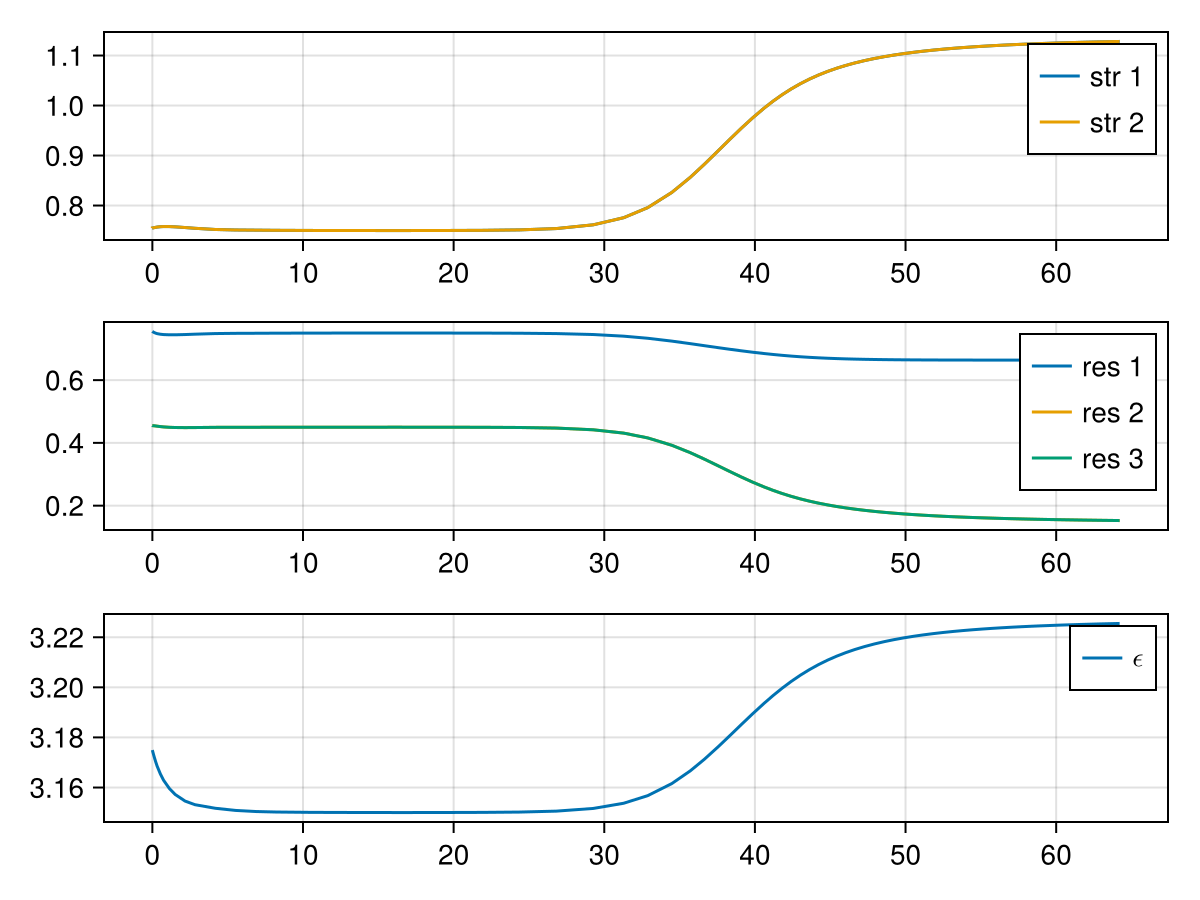

In [290]:
plot_smmicrm_sol_avgs(sps, 1:80; plote=true)

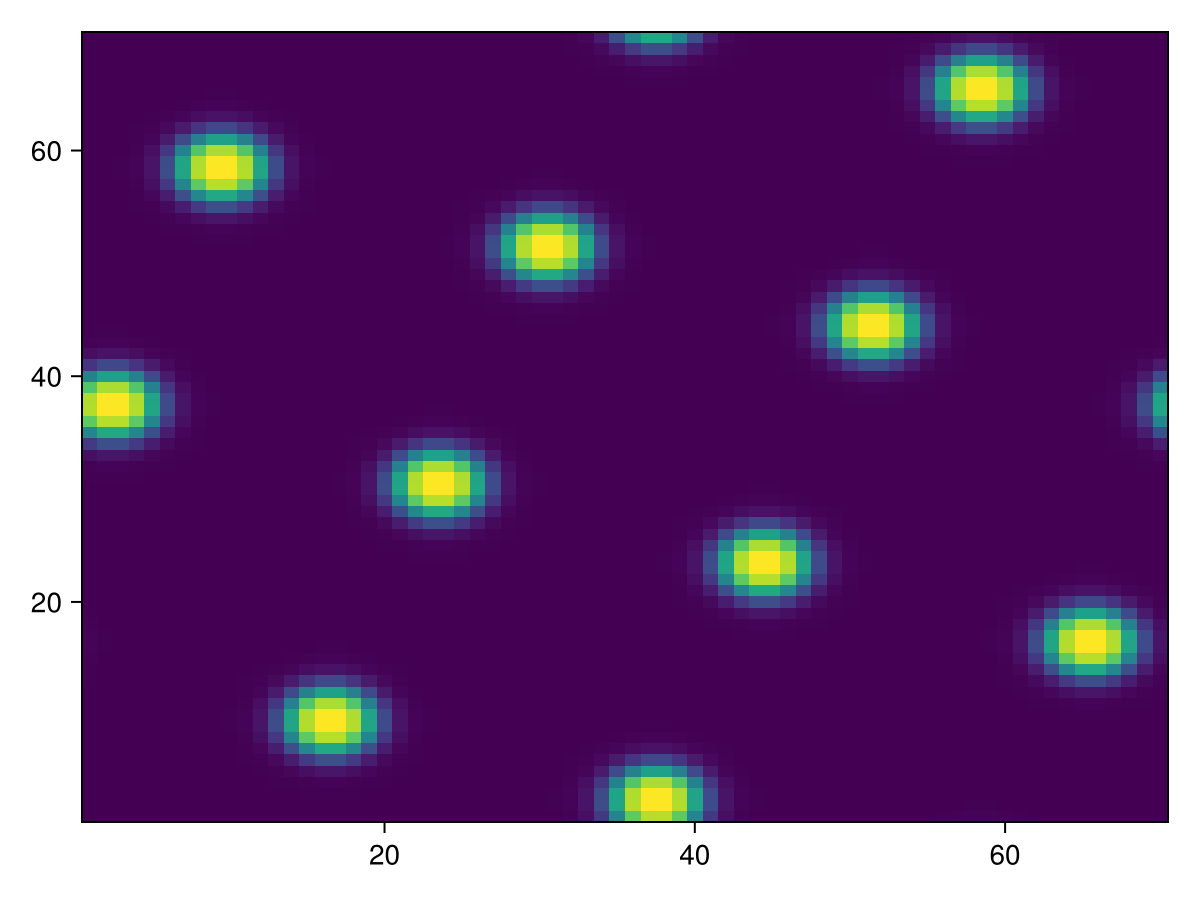

In [296]:
heatmap(sps.u[end][1,:,:])

In [264]:
sps.stats

SciMLBase.DEStats
Number of function 1 evaluations:                  1711
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    82
Number of linear solves:                           912
Number of Jacobians created:                       30
Number of nonlinear solver iterations:             625
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          226
Number of rejected steps:                          7

# Triplet 1

## Basic no space solve

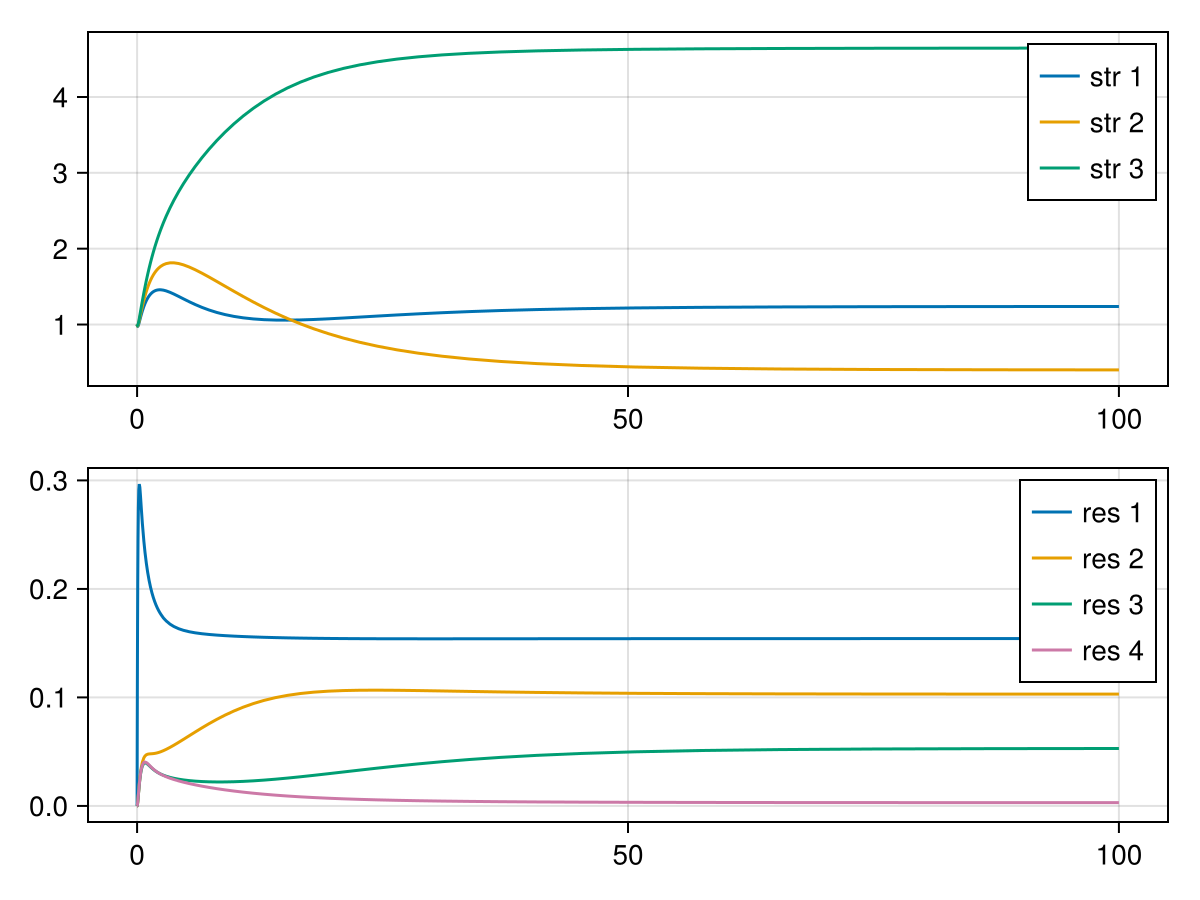

7-element Vector{Float64}:
 1.2380527966316084
 0.40194635851773436
 4.644320966335718
 0.15421816809606384
 0.10302353707609468
 0.05291835434841171
 0.00301247572973919

In [848]:
D = fill(0., 3, 4, 4)
c = fill(0., 3, 4)
l = fill(0., 3, 4)

c[:, 1] .= 5. # they "all" eat glucose
# c[1, 1] = 2.
# c[2, 1] = 3.
l[:, 1] .= 0.1 # and leak it

# what they leak it into
D[1, 3, 1] = 1.
D[2, 4, 1] = 1.
D[3, 2, 1] = 1.

# then they each eat their own resource
c[1, 2] = 2.
c[2, 3] = 2.
c[3, 4] = 2.

p = make_mmicrm_smart(3, 4, 100;
    D, c, l,
    K=[5.; fill(0., 3)],
    r=fill(1., 4),
    m=[0.9, 0.8, 0.7],
    u0=:onlyN,
    u0rand=0.
)
s = solve(p)
display(plot_mmicrm_sol(s))
s[end]
#param_summary(p.p)

In [845]:
sssol = solve(SteadyStateProblem(p), DynamicSS())
show(sssol)

[1.1490617559822638e-10, 2.8244881790122988e-5, 6.94282394404721, 0.1400001995334485, 0.0, 0.0, 0.0]

## Linear stability analysis

In [412]:
ks = LinRange(0., 10., 10000)
Ds = [fill(0.01, 3); 1000.; fill(0.01, 3)]
usol = s.u[end]
#usol = sssol.u
#usol = Symbolics.value.(getindex.(symsol[2], 2))
show(uninplace(mmicrmfunc!)(usol, p.p, 0))

[1.1414864588747293e-7, -1.2751542889861157e-7, -1.579327820083201e-8, 4.259092634129047e-9, -1.2405137361781726e-8, 4.658058438966606e-8, -1.2388329140300414e-8]

maximum(real(lambdas)) = 0.05818312607341076


[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.354196
[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.369300
[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.369300


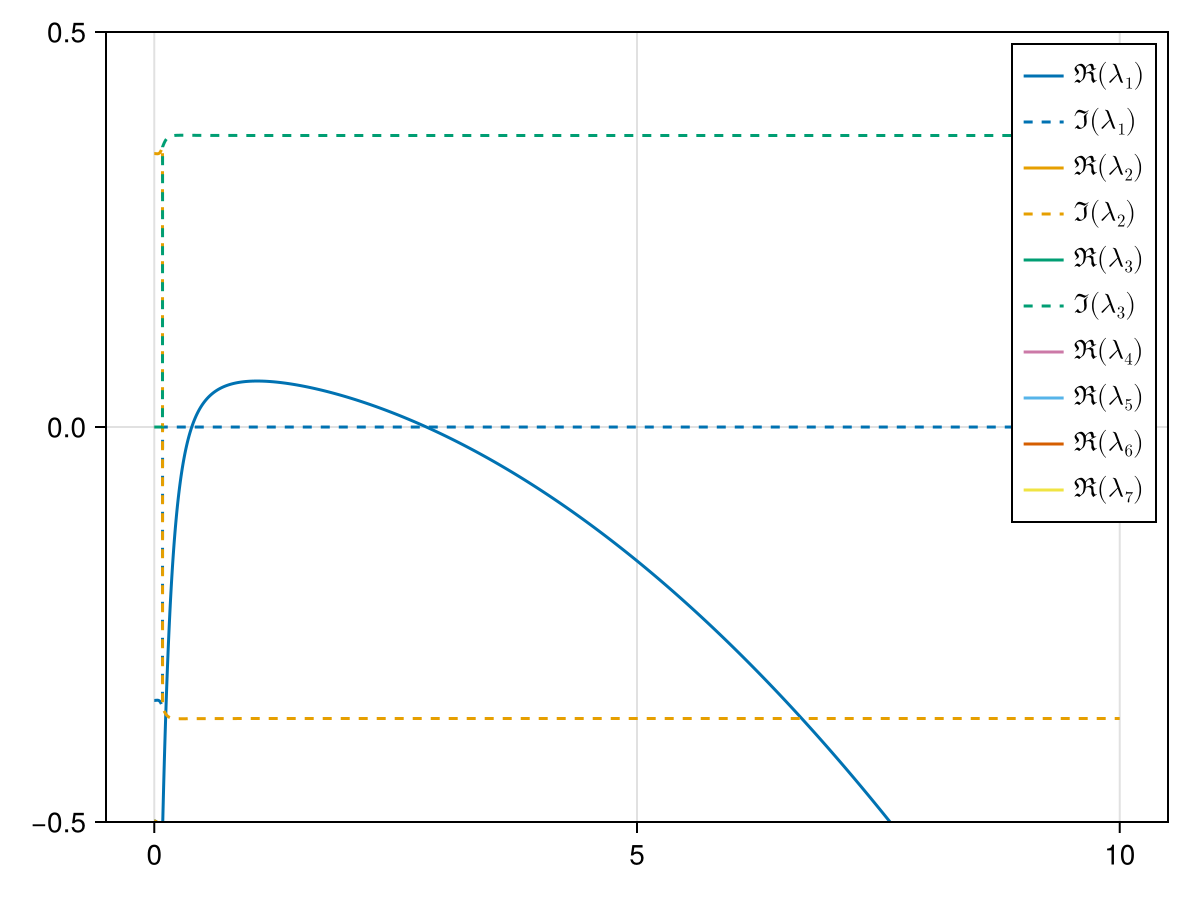

In [413]:
lambdas = do_linstab_for_ks(ks, p, Ds, usol);
@show maximum(real(lambdas))
faa = plot_linstab_lambdas(ks, lambdas[:,:])
ylims!(faa.axis, (-0.5, 0.5))
#xlims!(faa.axis, (0., 2.))
faa

In [414]:
# Finds the k with the biggest maximum eigenvalue
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
kmax_i, kmax

(1067, 1.0661066106610662)

In [417]:
ff = linstab_make_full_func(p.p, usol, Ds)
kmax_es = ff(kmax)
kmax_es.vectors[:,1] # the eigensystem is sorted by evalue so this is the one

7-element Vector{ComplexF64}:
    -0.683586667386004 + 0.0im
   -0.3547497600055367 + 0.0im
   -0.6373447768038648 + 0.0im
 0.0014693662286334272 + 0.0im
 -0.013317630664574384 + 0.0im
 -0.017059789206013306 + 0.0im
 -0.013526148659429882 + 0.0im

## Spatial stuff - 1D!

In [418]:
ssize = (1000,)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.1, 0.1)
space = make_cartesianspace_smart(length(ssize); dx=0.05, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 10000, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((7, 1000), 18, CartesianSpace{1, Tuple{Periodic}, Float64}([0.05]))

#### Direct solver

  0.780805 seconds (338.38 k allocations: 703.703 MiB)


ReturnCode.Success = 1

1306

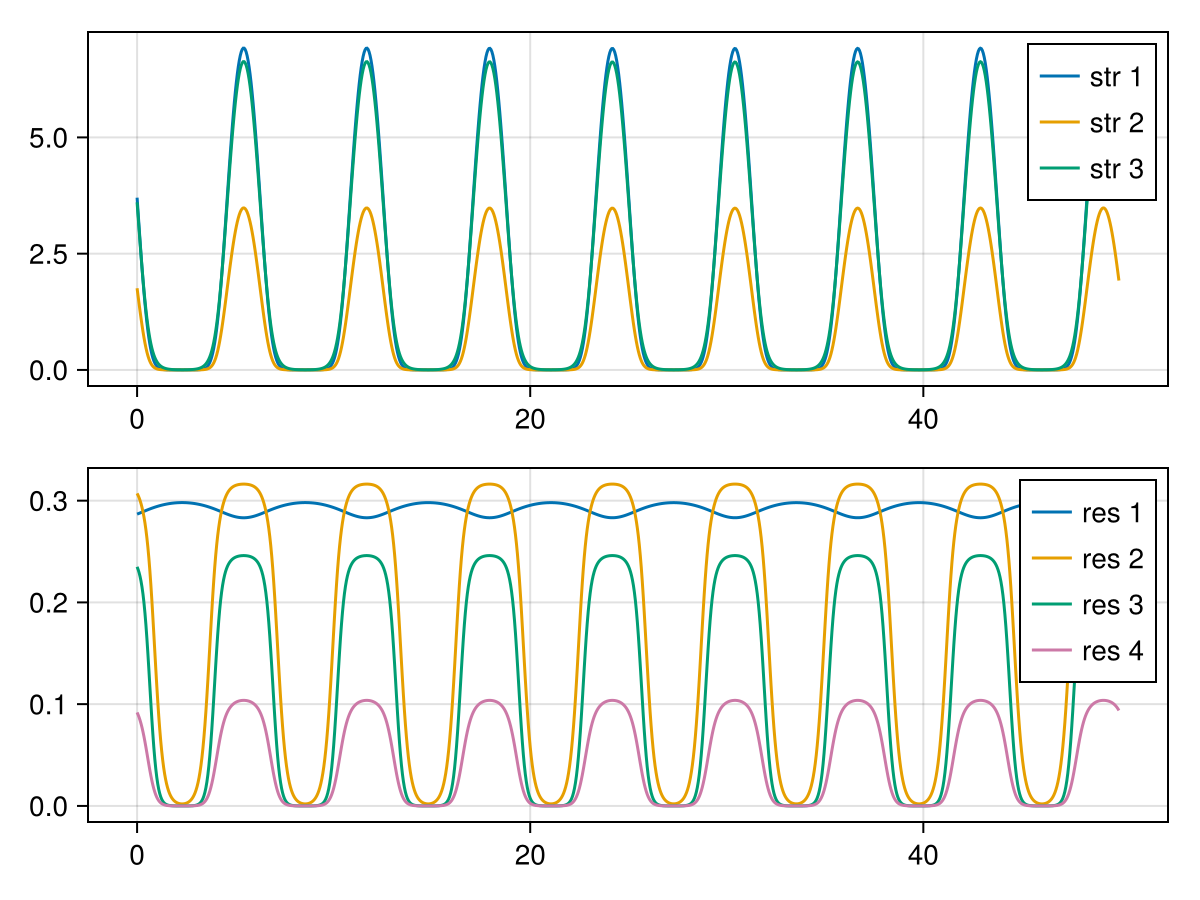

In [419]:
@time sps = solve(sp, QNDF(); maxiters=1000)
display(sps.retcode)
display(sps.destats.nf)
#display(plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end-1]))
plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

In [334]:
sps.stats

SciMLBase.DEStats
Number of function 1 evaluations:                  811
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    65
Number of linear solves:                           535
Number of Jacobians created:                       8
Number of nonlinear solver iterations:             476
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          169
Number of rejected steps:                          9

#### Steady state solver

 12.204321 seconds (836.84 k allocations: 2.199 GiB, 1.90% gc time)


ReturnCode.Success = 1

2803

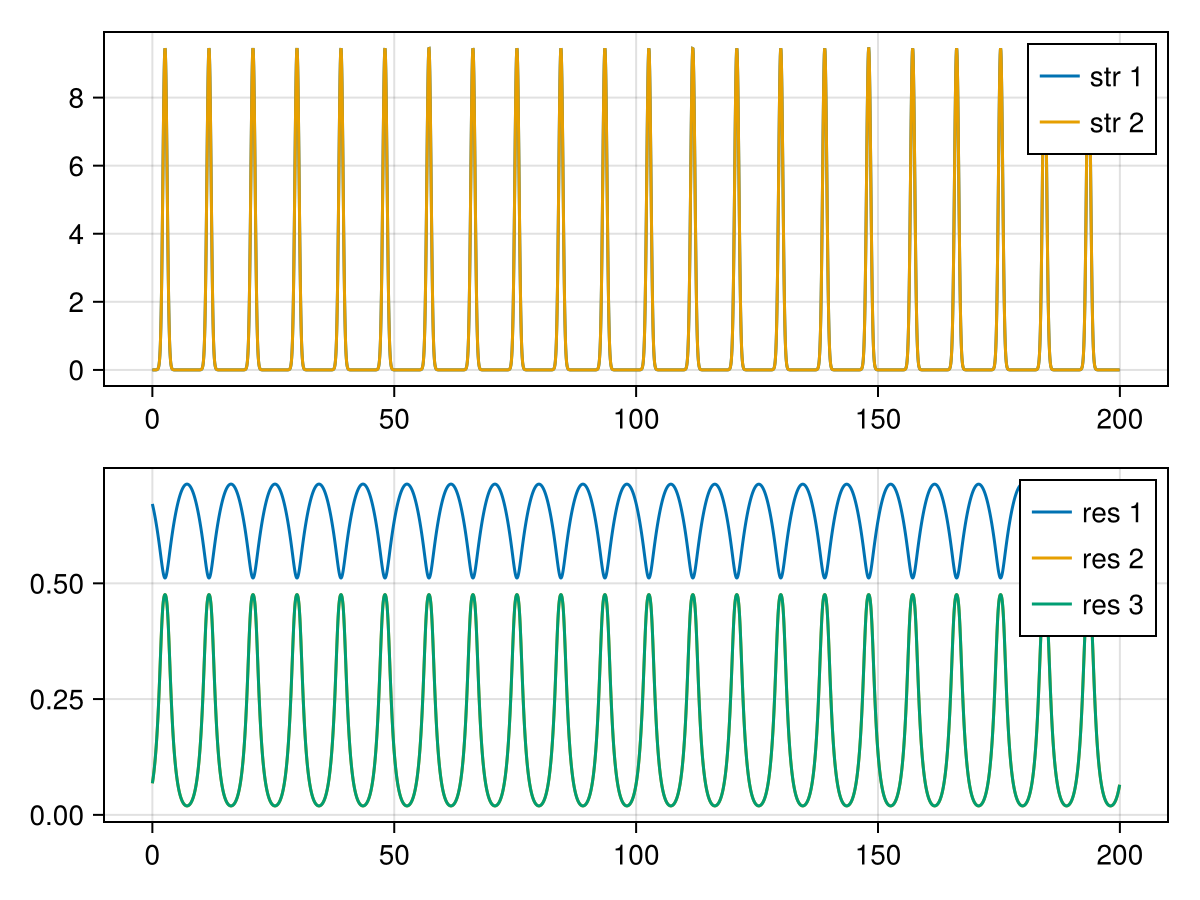

In [87]:
sssp = SteadyStateProblem(sp)
@time sssps = solve(sssp, DynamicSS(QNDF()); maxiters=1000)
display(sssps.retcode)
display(sssps.original.destats.nf)
plot_1dsmmicrm_sol_snap(sssps.prob.p, sssps.u)

## Spatial stuff - 2D!

In [420]:
ssize = (50,50)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.01, 0.01)
space = make_cartesianspace_smart(length(ssize); dx=0.1, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 100000, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((7, 50, 50), 18, CartesianSpace{2, Tuple{Periodic, Periodic}, Float64}([0.1, 0.1]))

#### Direct solver

In [421]:
@time sps = solve(sp, QNDF(); maxiters=1000)
display(sps.retcode)
display(sps.destats.nf)
@show length(sps.u)
#display(plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end-1]))
#plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

 29.228900 seconds (414.54 k allocations: 5.114 GiB, 1.04% gc time)


ReturnCode.Success = 1

688

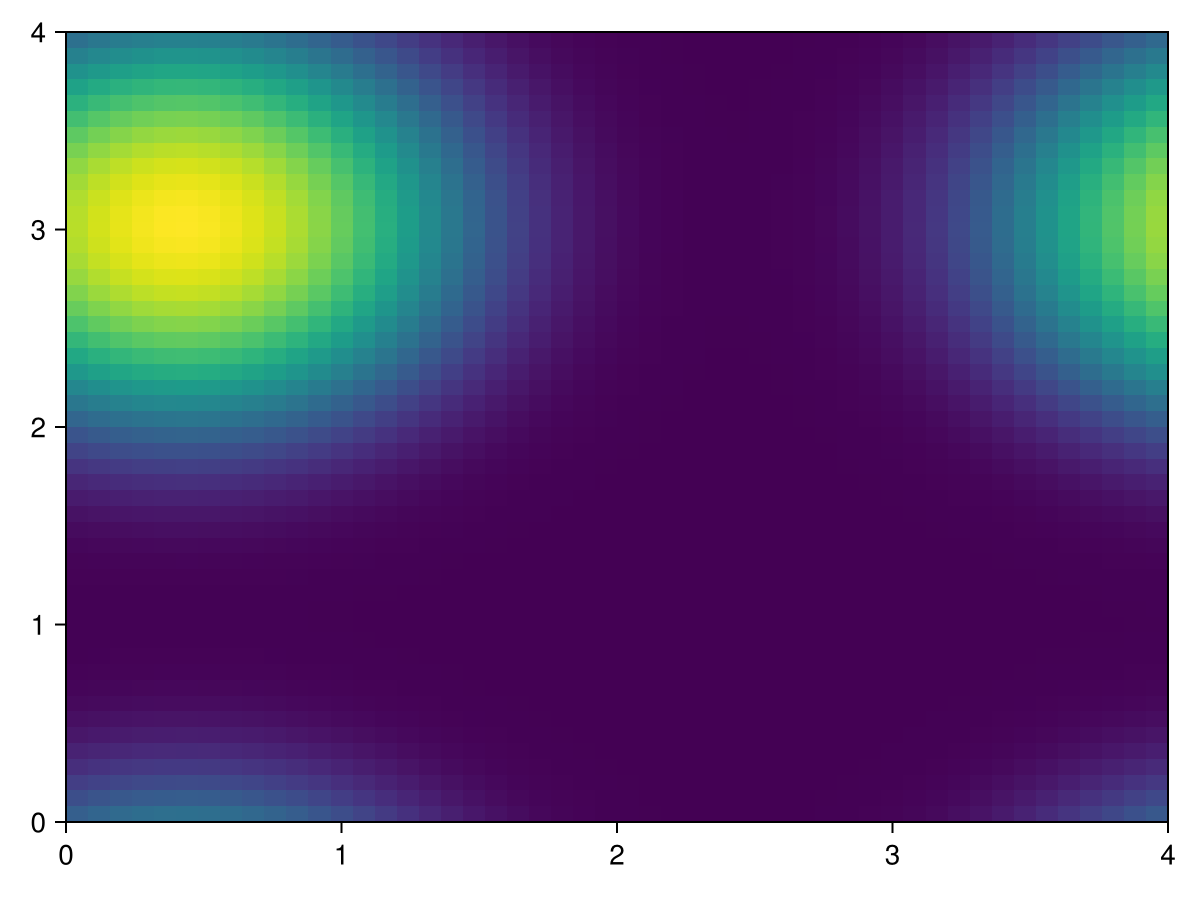

In [468]:
_size = size(sps.u[1][1,:,:])
dx = sps.prob.p.space.dx
heatmap(0:(_size[1]-1).*dx[1], 0:(_size[2]-1).*dx[2], sps.u[100][1,:,:])

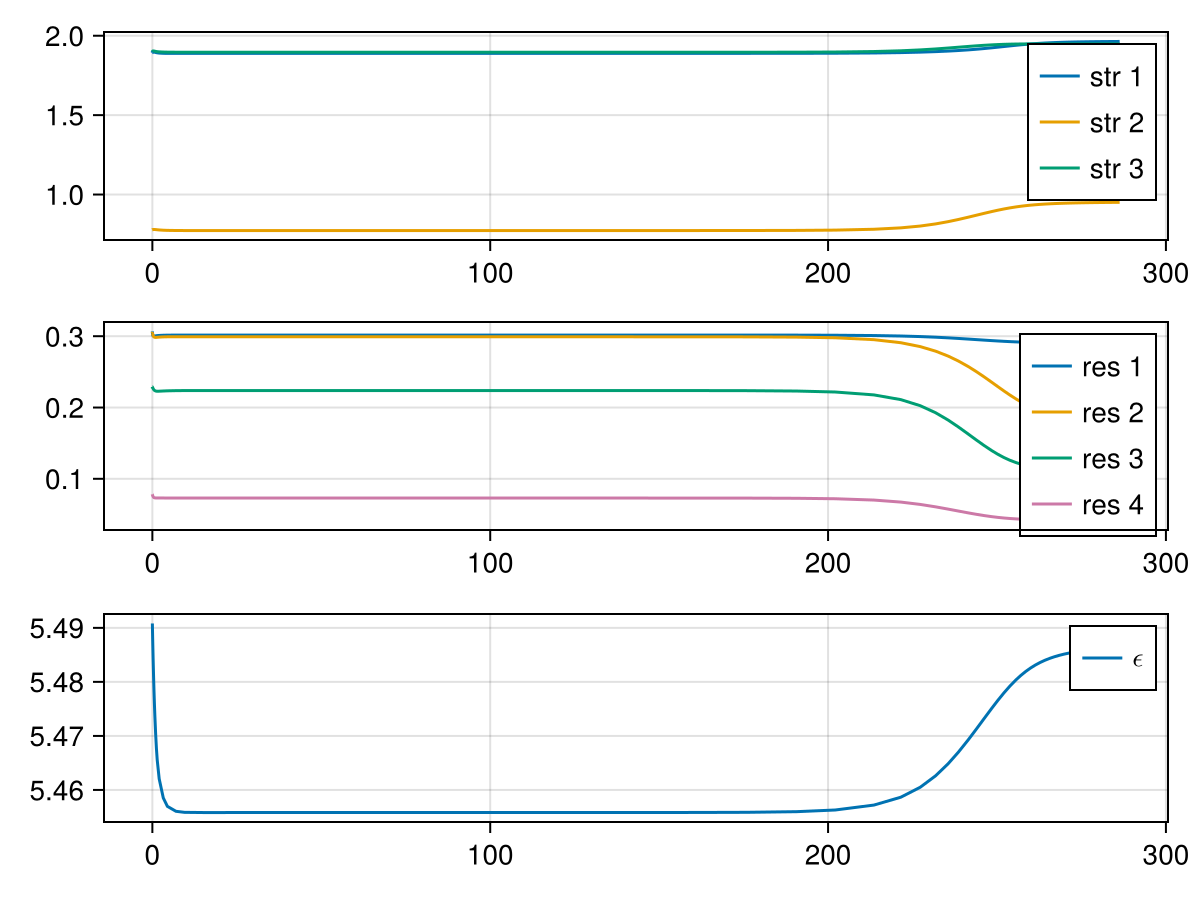

In [469]:
plot_smmicrm_sol_avgs(sps, 1:80; plote=true)

# Cosmo +1 parasite

## Basic no space solve

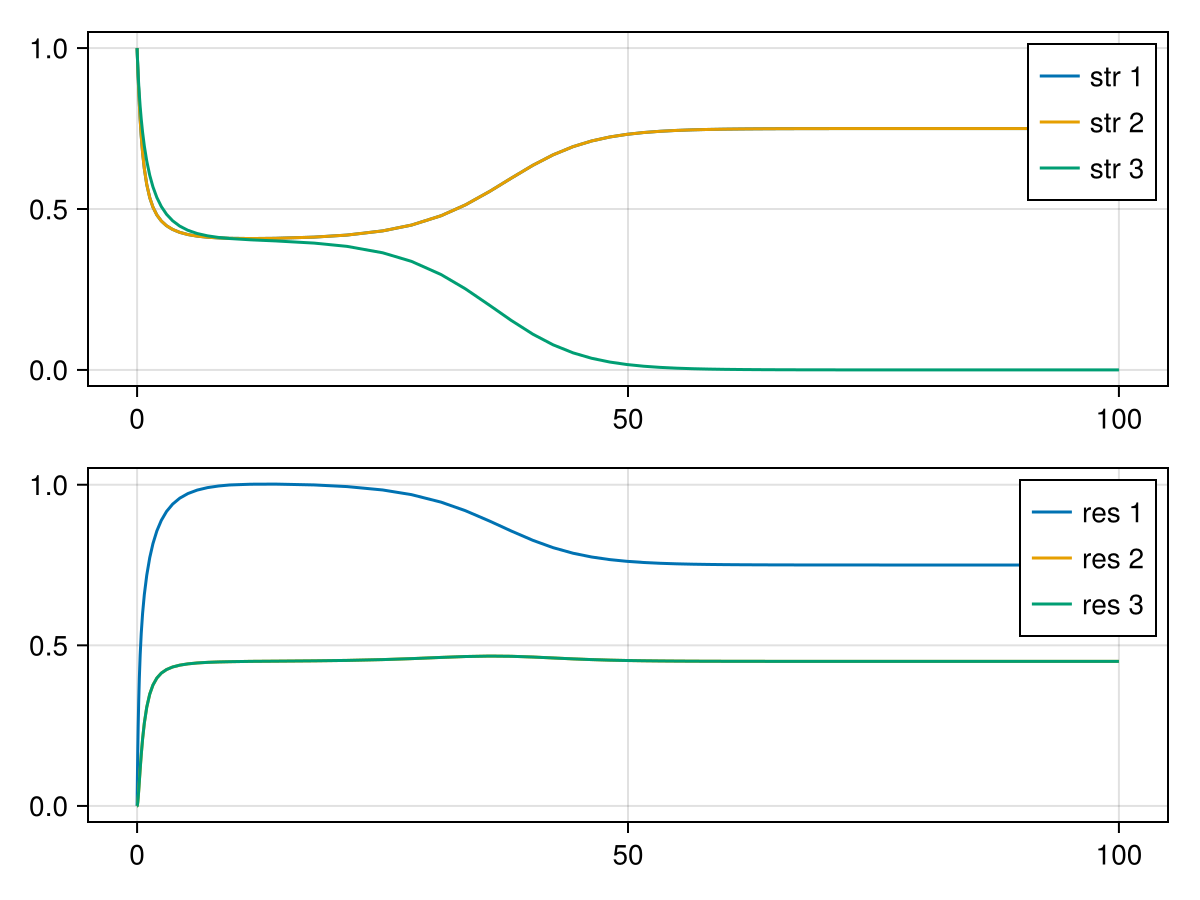

6-element Vector{Float64}:
 0.7499999226763895
 0.7499999226763951
 7.149818403779465e-8
 0.7500000487843239
 0.4500000117918312
 0.4500000117918311

In [817]:
D = fill(0., 3, 3, 3)
c = fill(0., 3, 3)
l = fill(0., 3, 3)

# Basic cosmo
D[1, 3, 1] = 1.
D[2, 2, 1] = 1.
c[:, 1] .= 2.
l[:, 1] .= 1.
c[1, 2] = 2.
c[2, 3] = 2.

# add the parasite
c[3, 1] = 0.895
l[3, 1] = 0

p = make_mmicrm_smart(3, 3, 100;
    D, c, l,
    K=[3., 0., 0.],
    r=fill(1., 3),
    m=[0.9, 0.9, 0.9],
    u0=:onlyN,
    u0rand=0.
)
s = solve(p)
display(plot_mmicrm_sol(s))
s[end]
#param_summary(p.p)

In [637]:
symsol = symbolic_solve_ode_ml(p)

LoadError: InterruptException:

In [638]:
sssol = solve(SteadyStateProblem(p), DynamicSS())
@show maximum(sssol.resid)
show(sssol)

maximum(sssol.resid) = 5.721682462973254e-7
[0.7499989042110579, 0.7499989042110579, 1.5243624788201993e-11, 0.7500009598884636, 0.4500003814466724, 0.4500003814466724]

## Linear stability analysis

In [818]:
ks = LinRange(0., 10., 10000)
Ds = [0.01, 0.01, 0., 1e2, 1., 1.]
usol = s.u[end]
#usol = sssol.u
#usol = Symbolics.value.(getindex.(symsol[2], 2))
show(uninplace(mmicrmfunc!)(usol, p.p, 0))

[1.768774494367368e-8, 1.7687744777140378e-8, -1.6355206476893965e-8, -1.115961678621602e-8, -2.6972555300375234e-9, -2.697269074758424e-9]

maximum(real(lambdas)) = 0.23503415765958943


[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 1.427410
[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 1.427410


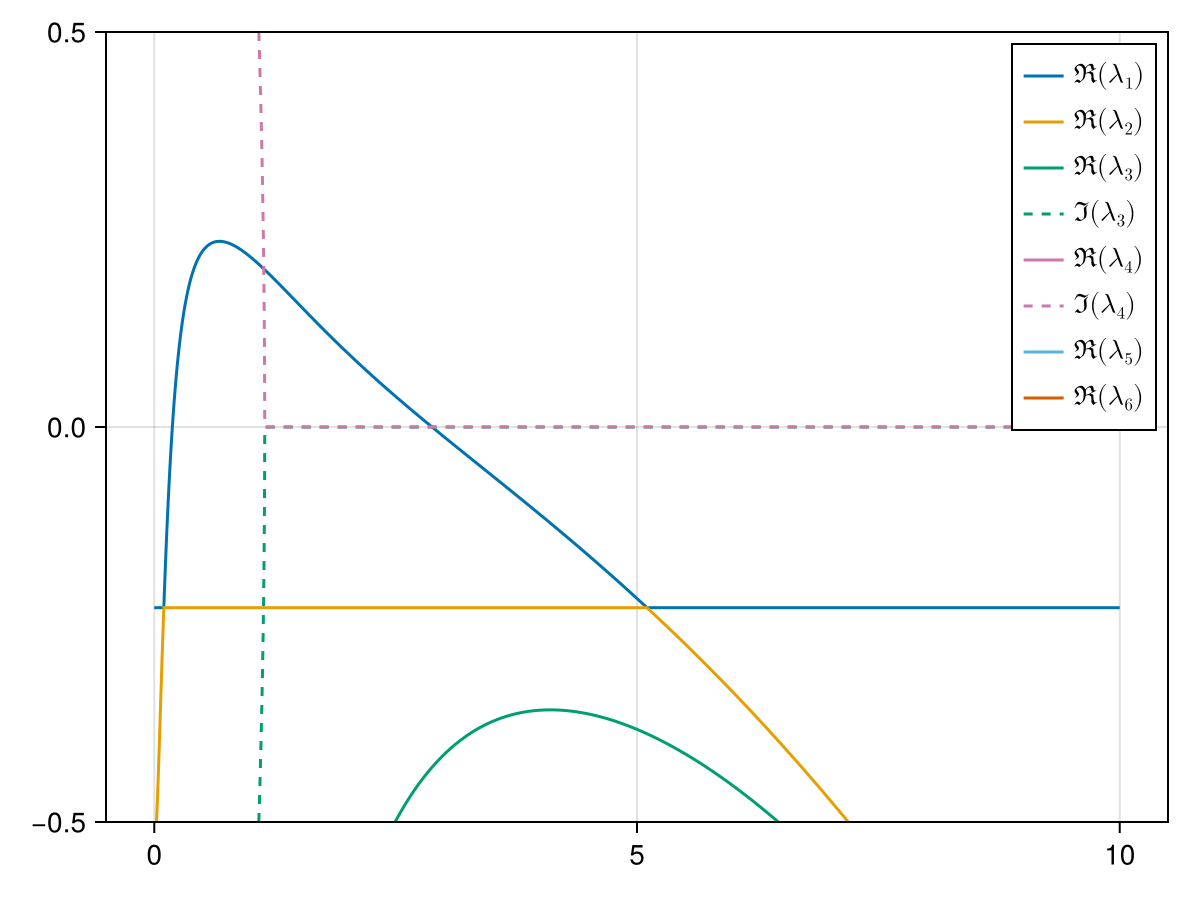

In [819]:
lambdas = do_linstab_for_ks(ks, p, Ds, usol);
@show maximum(real(lambdas))
faa = plot_linstab_lambdas(ks, lambdas[:,:])
ylims!(faa.axis, (-0.5, 0.5))
#xlims!(faa.axis, (0., 2.))
faa

In [820]:
# Finds the k with the biggest maximum eigenvalue
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
kmax_i, kmax

(676, 0.6750675067506751)

In [821]:
ff = linstab_make_full_func(p.p, usol, Ds)
kmax_es = ff(kmax)
kmax_es.vectors[:,1] # the eigensystem is sorted by evalue so this is the one

6-element Vector{ComplexF64}:
   0.6976388762383224 + 0.0im
   0.6976388762383234 + 0.0im
 -5.79784809109922e-9 + 0.0im
 -0.04202083164134554 + 0.0im
    0.111432146237138 + 0.0im
  0.11143214623713715 + 0.0im

## Spatial stuff - 1D!

In [737]:
collect(CartesianIndices((10,3)))

10×3 Matrix{CartesianIndex{2}}:
 CartesianIndex(1, 1)   CartesianIndex(1, 2)   CartesianIndex(1, 3)
 CartesianIndex(2, 1)   CartesianIndex(2, 2)   CartesianIndex(2, 3)
 CartesianIndex(3, 1)   CartesianIndex(3, 2)   CartesianIndex(3, 3)
 CartesianIndex(4, 1)   CartesianIndex(4, 2)   CartesianIndex(4, 3)
 CartesianIndex(5, 1)   CartesianIndex(5, 2)   CartesianIndex(5, 3)
 CartesianIndex(6, 1)   CartesianIndex(6, 2)   CartesianIndex(6, 3)
 CartesianIndex(7, 1)   CartesianIndex(7, 2)   CartesianIndex(7, 3)
 CartesianIndex(8, 1)   CartesianIndex(8, 2)   CartesianIndex(8, 3)
 CartesianIndex(9, 1)   CartesianIndex(9, 2)   CartesianIndex(9, 3)
 CartesianIndex(10, 1)  CartesianIndex(10, 2)  CartesianIndex(10, 3)

In [822]:
ssize = (1000,)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.1, 0.1)
for sci in CartesianIndices(ssize)
    psu0[3,sci] += 1
end
space = make_cartesianspace_smart(length(ssize); dx=0.05, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 10000, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((6, 1000), 18, CartesianSpace{1, Tuple{Periodic}, Float64}([0.05]))

#### Direct solver

  1.667721 seconds (257.56 k allocations: 379.729 MiB, 34.43% gc time)


ReturnCode.Success = 1

846

length(sps.u) = 184


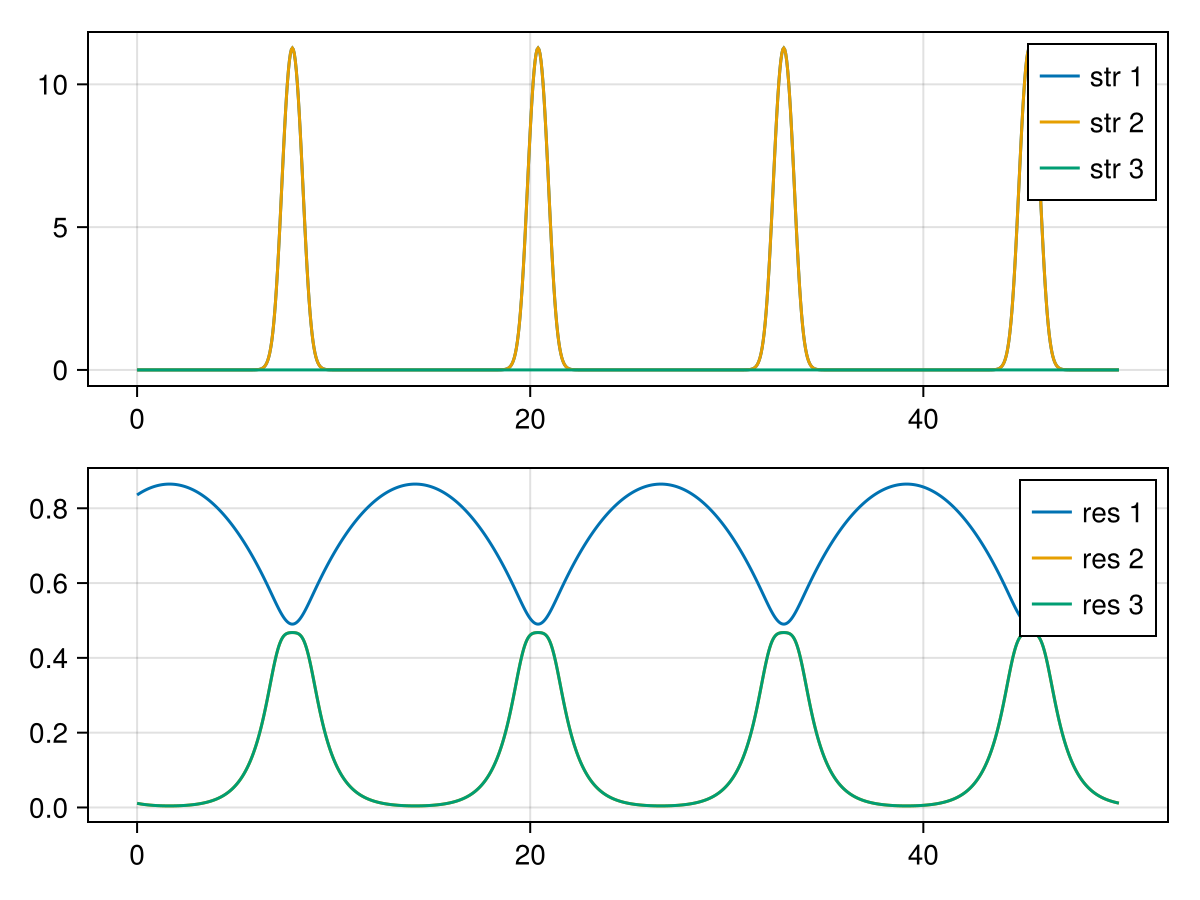

In [823]:
@time sps = solve(sp, QNDF(); maxiters=1000)
display(sps.retcode)
display(sps.destats.nf)
#display(plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end-1]))
@show length(sps.u)
plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

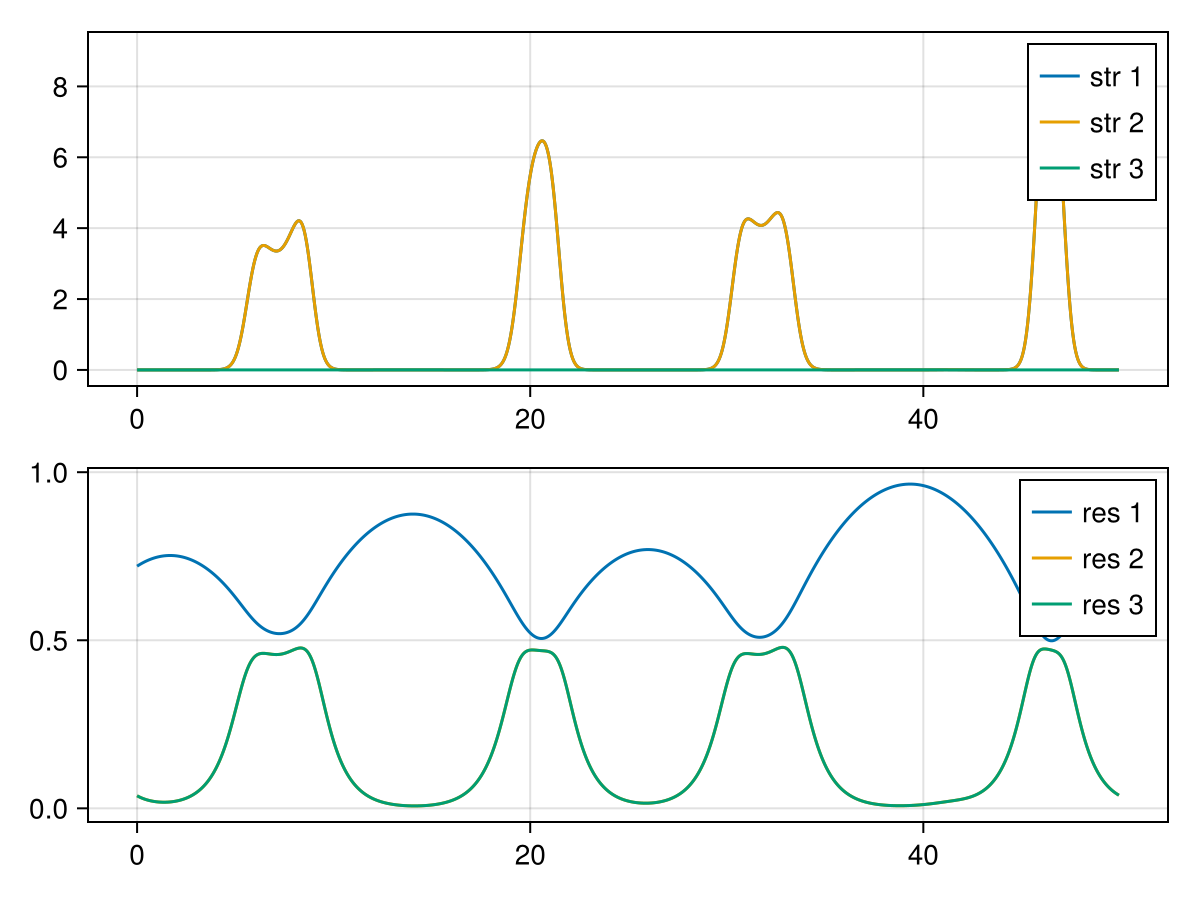

In [836]:
plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[100])

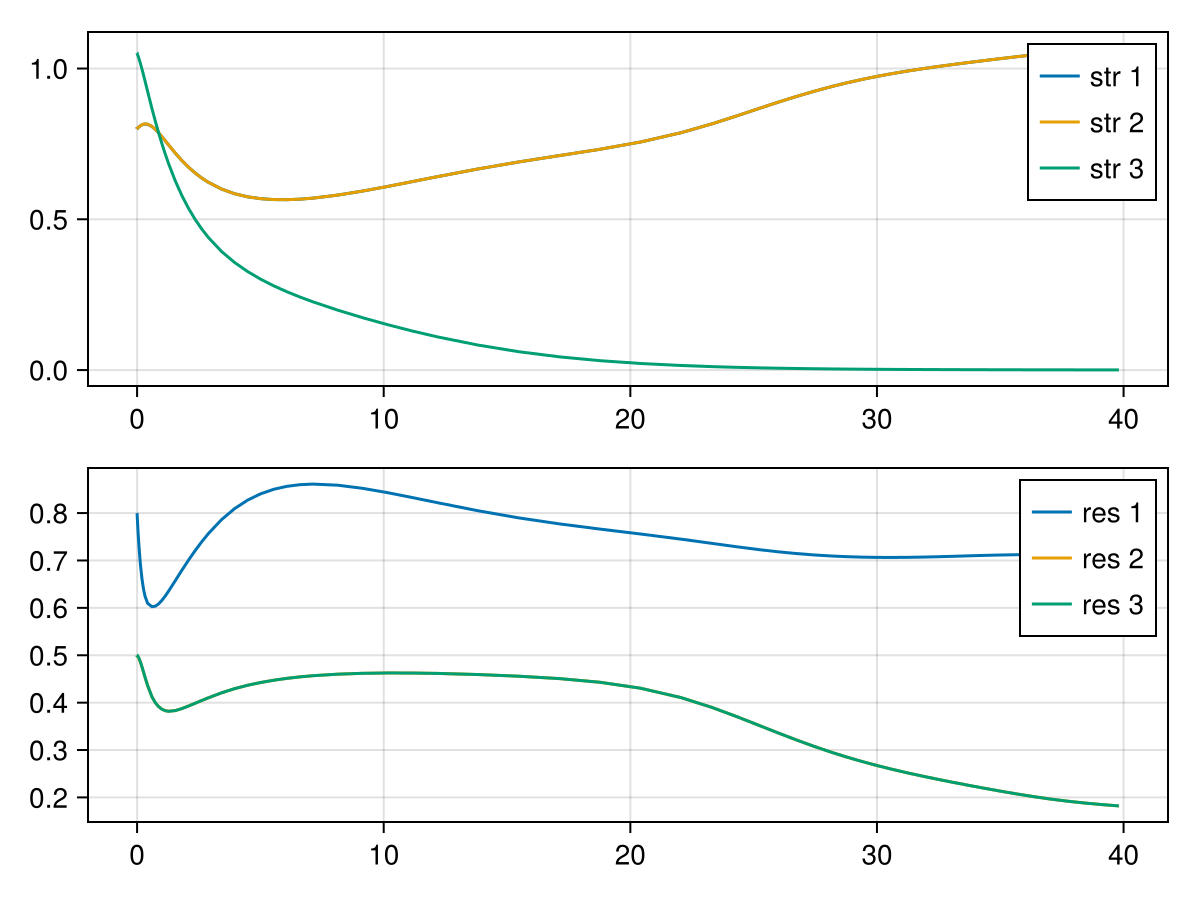

In [825]:
plot_smmicrm_sol_avgs(sps, 1:100)

#### Steady state solver

 12.204321 seconds (836.84 k allocations: 2.199 GiB, 1.90% gc time)


ReturnCode.Success = 1

2803

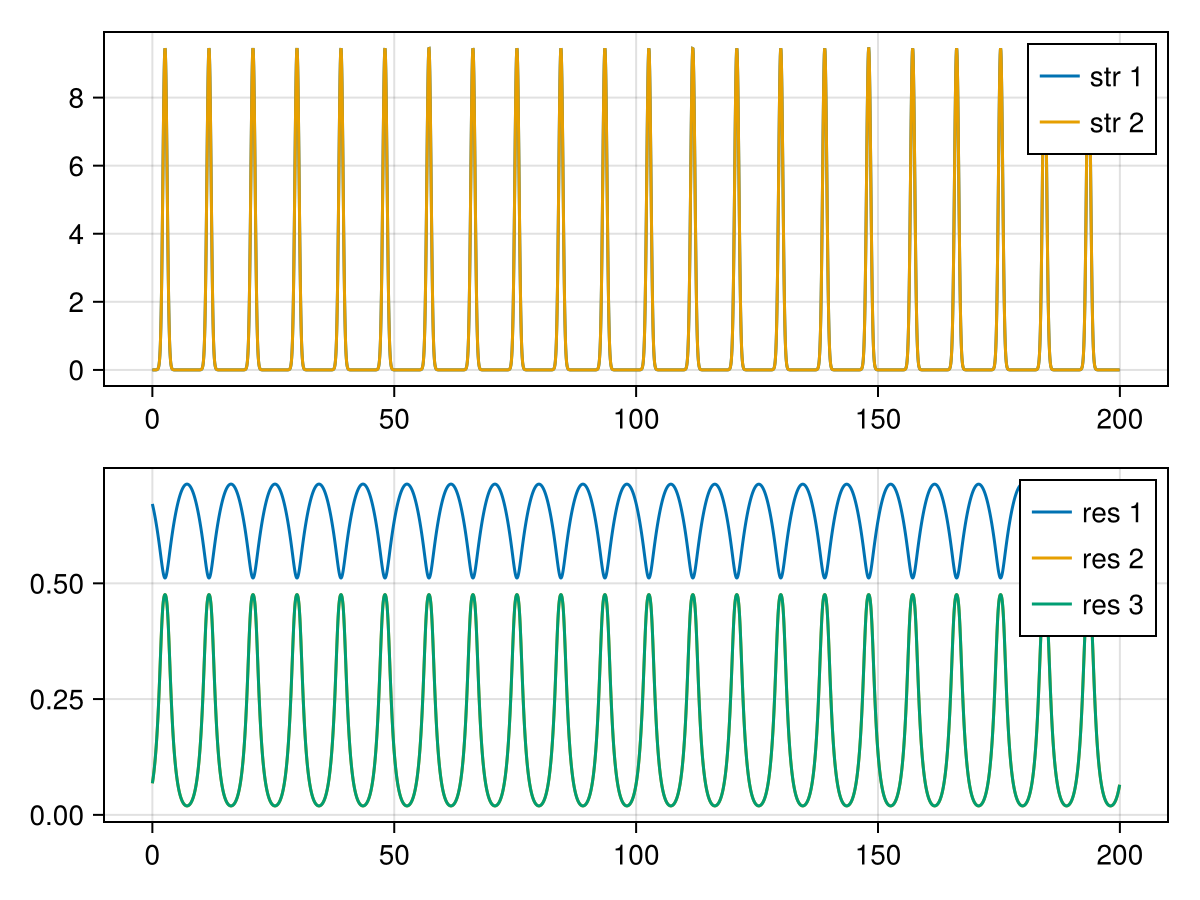

In [87]:
sssp = SteadyStateProblem(sp)
@time sssps = solve(sssp, DynamicSS(QNDF()); maxiters=1000)
display(sssps.retcode)
display(sssps.original.destats.nf)
plot_1dsmmicrm_sol_snap(sssps.prob.p, sssps.u)

## Spatial stuff - 2D!

In [741]:
ssize = (30,30)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.01, 0.01)
for sci in CartesianIndices(ssize)
    psu0[3,sci] += 1
end
space = make_cartesianspace_smart(length(ssize); dx=0.3, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 10000, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((6, 30, 30), 18, CartesianSpace{2, Tuple{Periodic, Periodic}, Float64}([0.3, 0.3]))

#### Direct solver

In [757]:
@time sps = solve(sp, QNDF(); maxiters=1000)
display(sps.retcode)
display(sps.destats.nf)
@show length(sps.u)
#display(plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end-1]))
#plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

  3.202793 seconds (163.26 k allocations: 653.474 MiB)


ReturnCode.Success = 1

429

length(sps.u) = 98


98

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


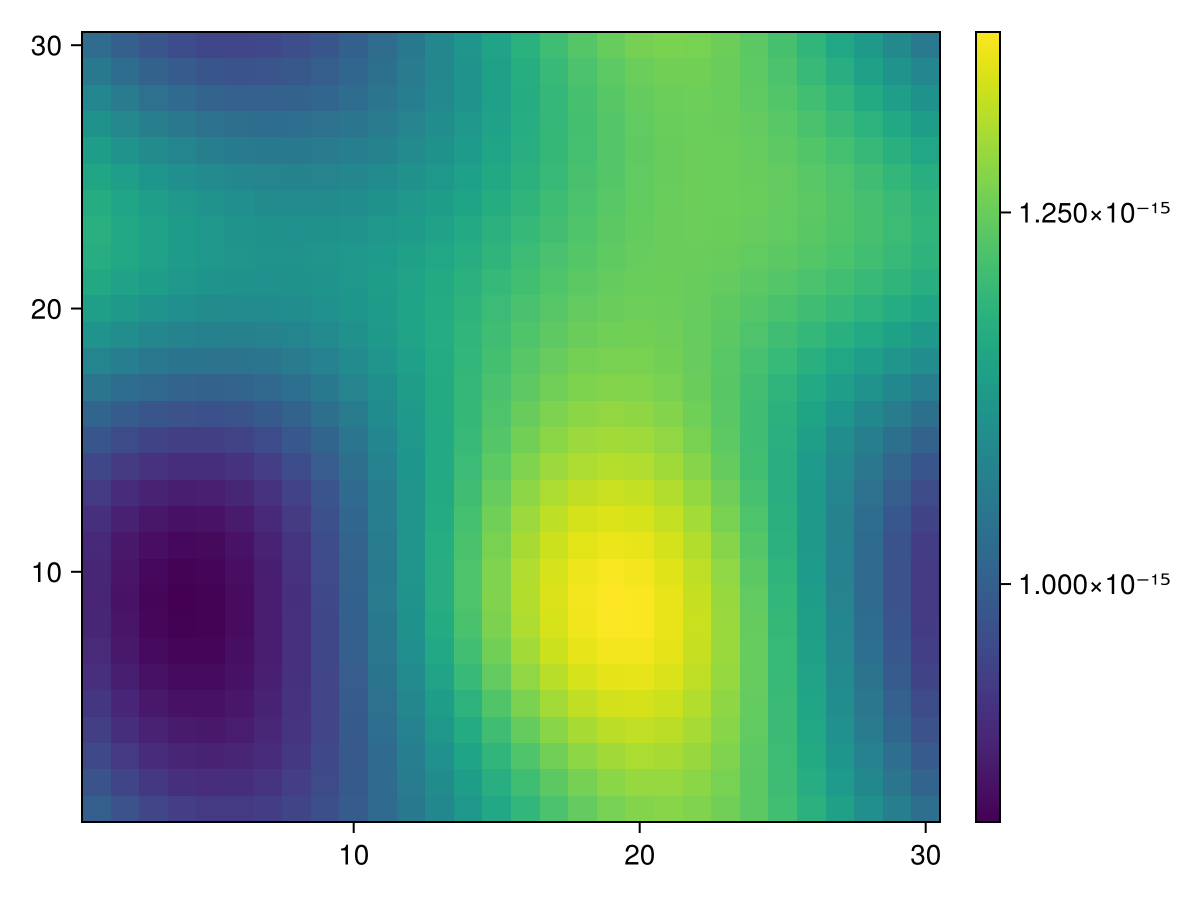

In [792]:
fap = heatmap(sps.u[end][2,:,:])
Colorbar(fap.figure[1,2], fap.plot)
fap

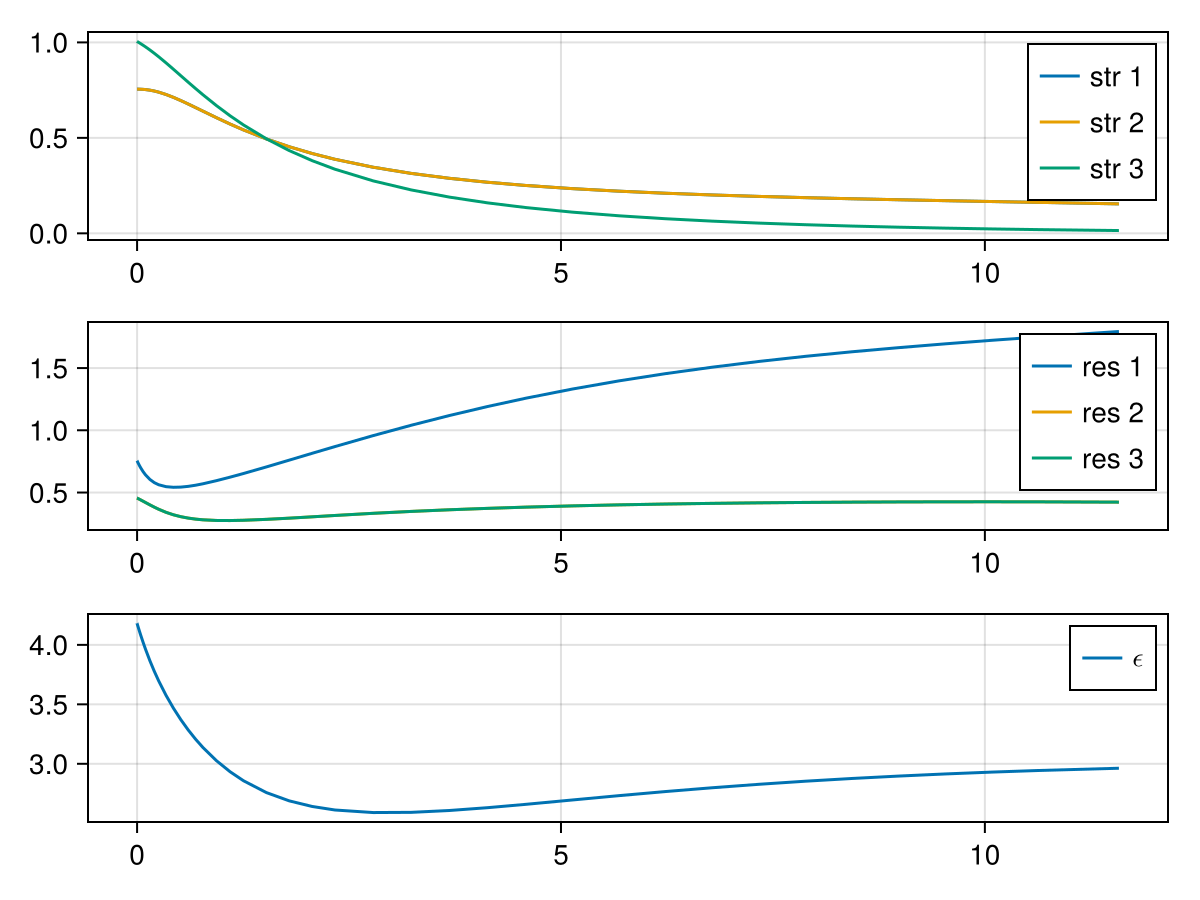

In [794]:
plot_smmicrm_sol_avgs(sps, 1:50; plote=true)

In [264]:
sps.stats

SciMLBase.DEStats
Number of function 1 evaluations:                  1711
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    82
Number of linear solves:                           912
Number of Jacobians created:                       30
Number of nonlinear solver iterations:             625
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          226
Number of rejected steps:                          7

# Triplet 2

## Basic no space solve

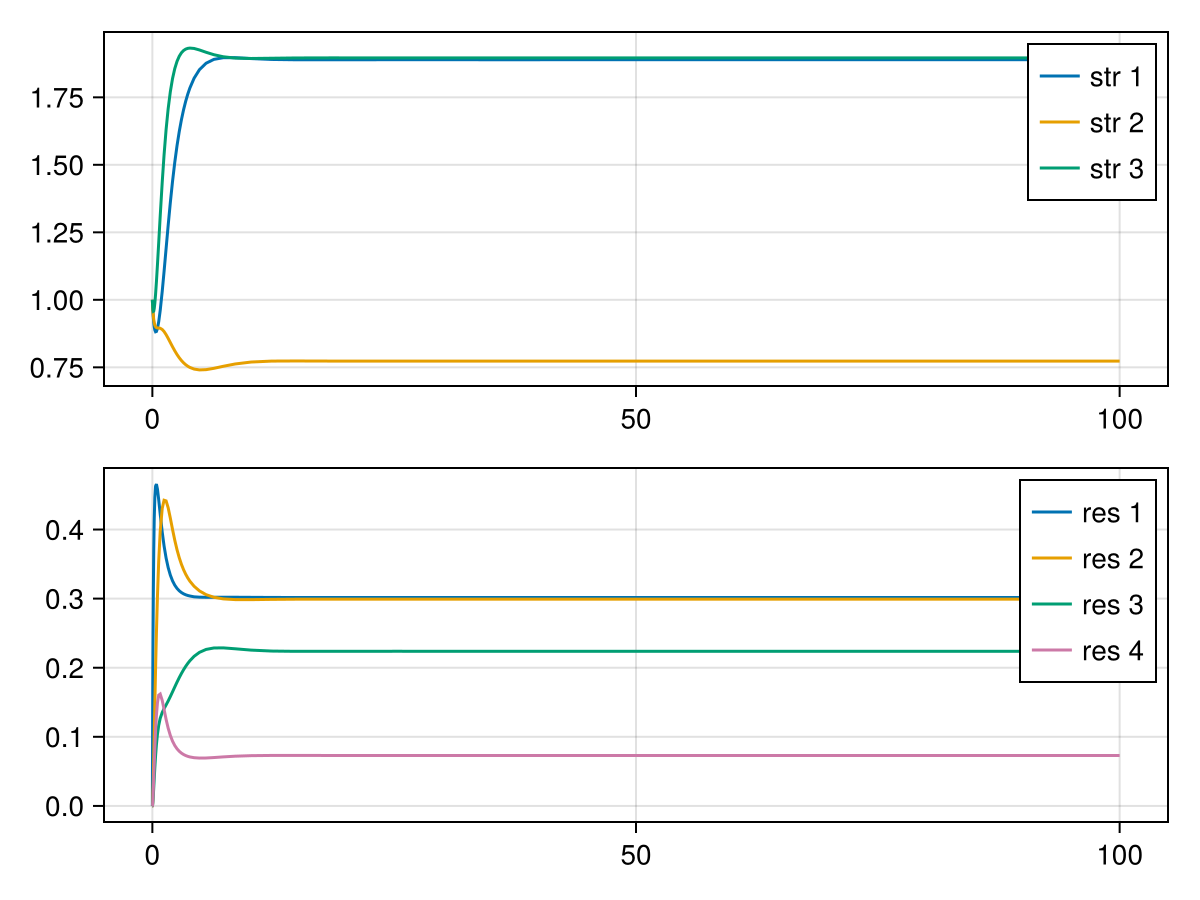

7-element Vector{Float64}:
 1.889171821442941
 0.7730573734531432
 1.8960133174635756
 0.3016121343876806
 0.2991939630174525
 0.22379081673448847
 0.07298482785053452

In [409]:
D = fill(0., 3, 4, 4)
c = fill(0., 3, 4)
l = fill(0., 3, 4)

c[:, 1] .= 5. # they "all" eat glucose
c[1, 1] = 2.
c[2, 1] = 3.
l[:, 1] .= 0.5 # and leak it

# what they leak it into
D[1, 3, 1] = 1.
D[2, 4, 1] = 1.
D[3, 2, 1] = 1.

# then they each eat their own resource
c[1, 2] = 2.
c[2, 3] = 2.
c[3, 4] = 2.

p = make_mmicrm_smart(3, 4, 100;
    D, c, l,
    K=[5.; fill(0., 3)],
    r=fill(1., 4),
    m=fill(0.9, 3),
    u0=:onlyN,
    u0rand=0.
)
s = solve(p)
display(plot_mmicrm_sol(s))
s[end]
#param_summary(p.p)

#### Steady state solving

In [315]:
symsol = symbolic_solve_ode_ml(p)

LoadError: InterruptException:

In [16]:
sssol = solve(SteadyStateProblem(p), DynamicSS())
show(sssol)

[0.7499991588608942, 0.7499991588608942, 0.7500007386390256, 0.4500002918297526, 0.4500002918297526]

## Linear stability analysis

In [412]:
ks = LinRange(0., 10., 10000)
Ds = [fill(0.01, 3); 1000.; fill(0.01, 3)]
usol = s.u[end]
#usol = sssol.u
#usol = Symbolics.value.(getindex.(symsol[2], 2))
show(uninplace(mmicrmfunc!)(usol, p.p, 0))

[1.1414864588747293e-7, -1.2751542889861157e-7, -1.579327820083201e-8, 4.259092634129047e-9, -1.2405137361781726e-8, 4.658058438966606e-8, -1.2388329140300414e-8]

maximum(real(lambdas)) = 0.05818312607341076


[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.354196
[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.369300
[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.369300


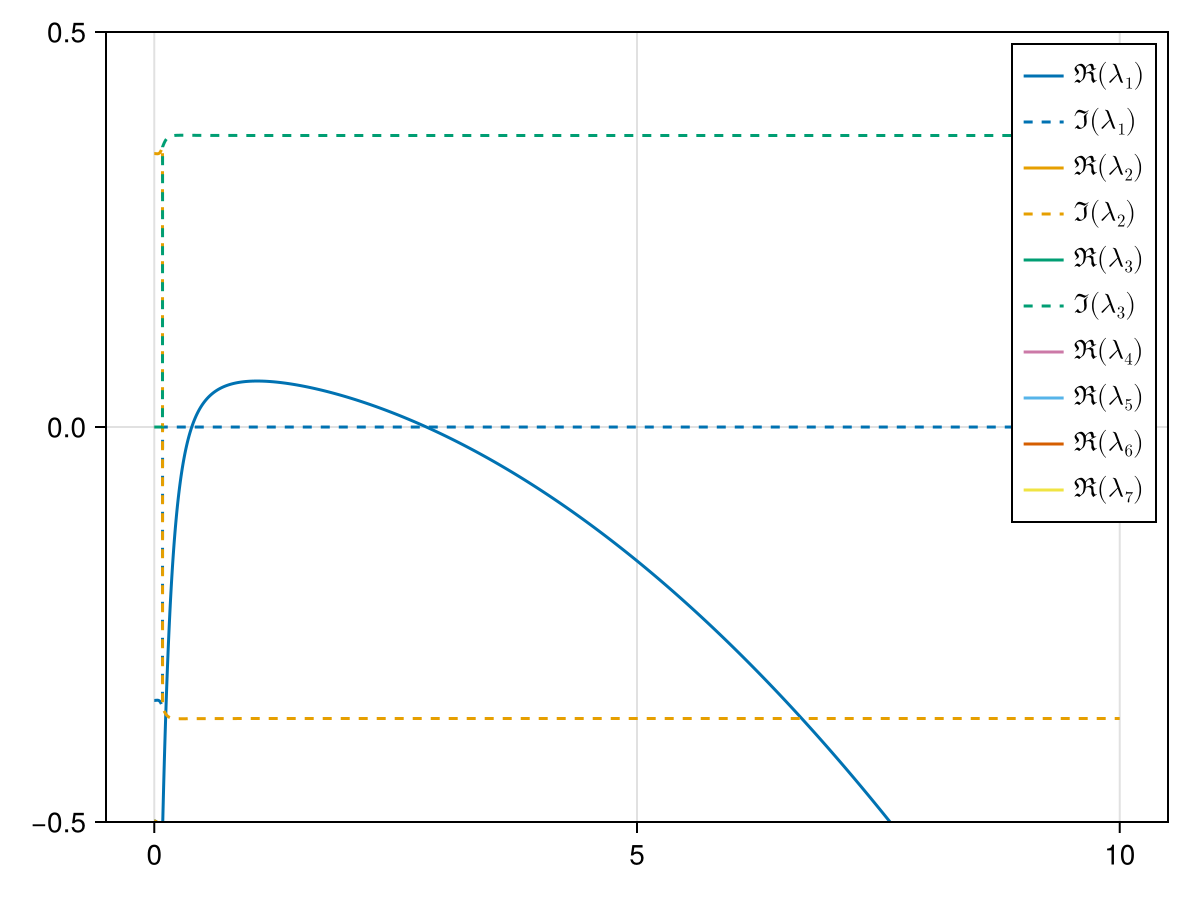

In [413]:
lambdas = do_linstab_for_ks(ks, p, Ds, usol);
@show maximum(real(lambdas))
faa = plot_linstab_lambdas(ks, lambdas[:,:])
ylims!(faa.axis, (-0.5, 0.5))
#xlims!(faa.axis, (0., 2.))
faa

In [414]:
# Finds the k with the biggest maximum eigenvalue
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
kmax_i, kmax

(1067, 1.0661066106610662)

In [417]:
ff = linstab_make_full_func(p.p, usol, Ds)
kmax_es = ff(kmax)
kmax_es.vectors[:,1] # the eigensystem is sorted by evalue so this is the one

7-element Vector{ComplexF64}:
    -0.683586667386004 + 0.0im
   -0.3547497600055367 + 0.0im
   -0.6373447768038648 + 0.0im
 0.0014693662286334272 + 0.0im
 -0.013317630664574384 + 0.0im
 -0.017059789206013306 + 0.0im
 -0.013526148659429882 + 0.0im

## Spatial stuff - 1D!

In [418]:
ssize = (1000,)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.1, 0.1)
space = make_cartesianspace_smart(length(ssize); dx=0.05, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 10000, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((7, 1000), 18, CartesianSpace{1, Tuple{Periodic}, Float64}([0.05]))

#### Direct solver

  0.780805 seconds (338.38 k allocations: 703.703 MiB)


ReturnCode.Success = 1

1306

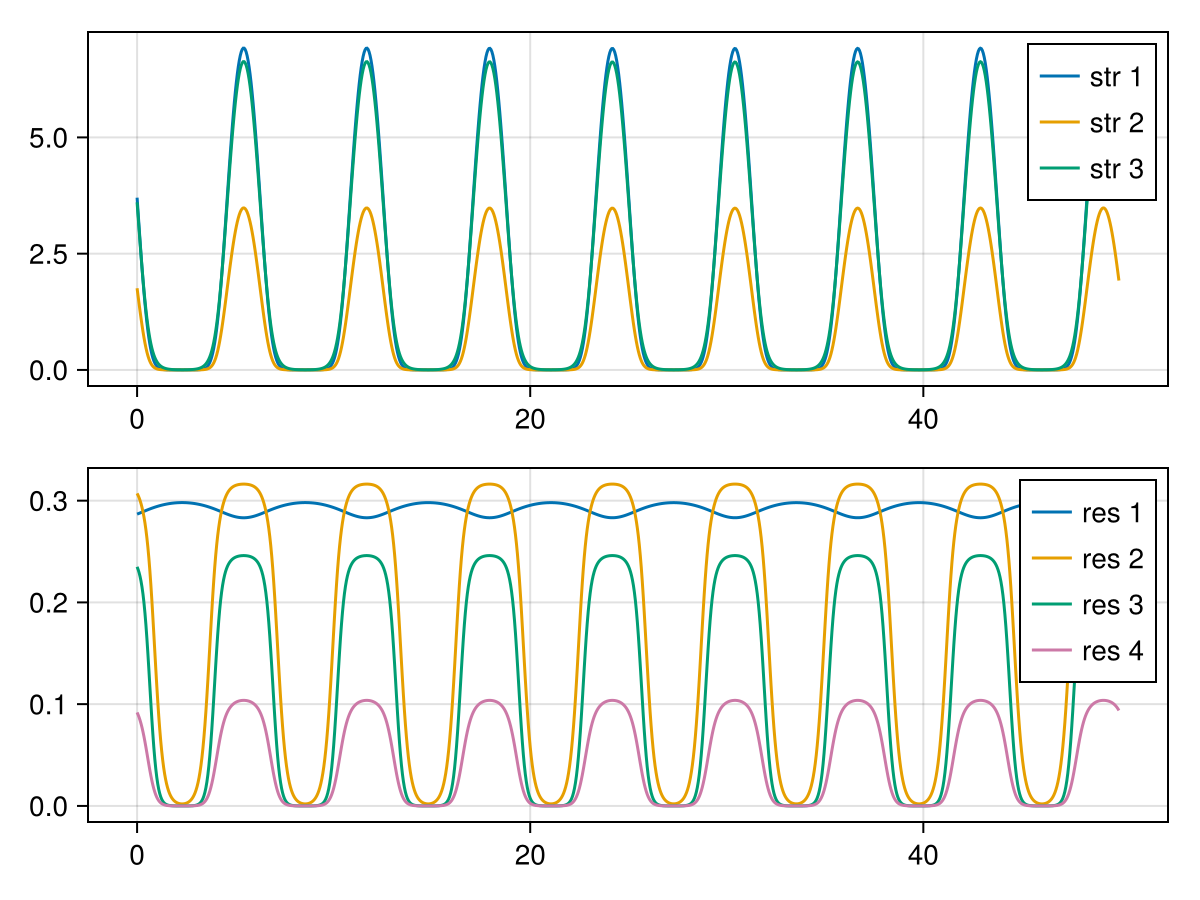

In [419]:
@time sps = solve(sp, QNDF(); maxiters=1000)
display(sps.retcode)
display(sps.destats.nf)
#display(plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end-1]))
plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

In [334]:
sps.stats

SciMLBase.DEStats
Number of function 1 evaluations:                  811
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    65
Number of linear solves:                           535
Number of Jacobians created:                       8
Number of nonlinear solver iterations:             476
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          169
Number of rejected steps:                          9

#### Steady state solver

 12.204321 seconds (836.84 k allocations: 2.199 GiB, 1.90% gc time)


ReturnCode.Success = 1

2803

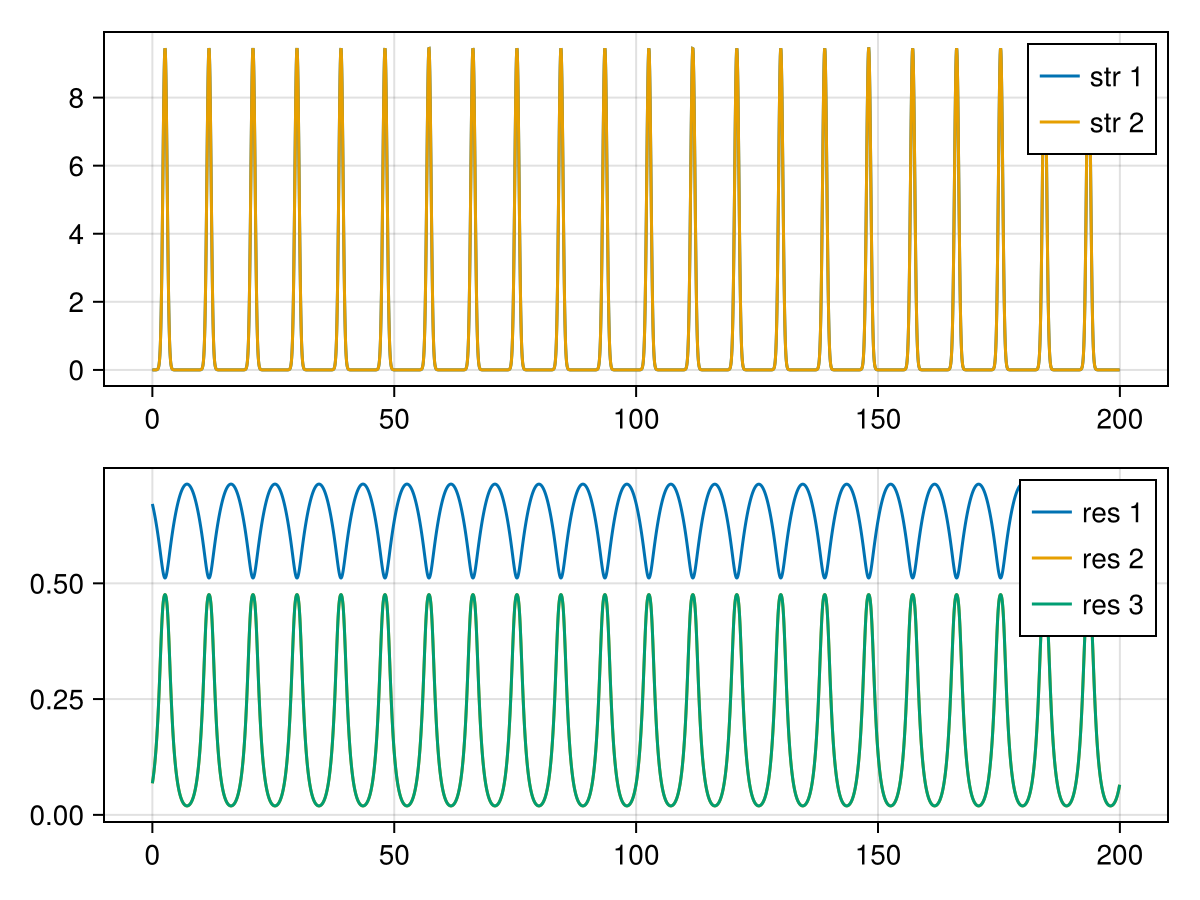

In [87]:
sssp = SteadyStateProblem(sp)
@time sssps = solve(sssp, DynamicSS(QNDF()); maxiters=1000)
display(sssps.retcode)
display(sssps.original.destats.nf)
plot_1dsmmicrm_sol_snap(sssps.prob.p, sssps.u)

## Spatial stuff - 2D!

In [420]:
ssize = (50,50)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.01, 0.01)
space = make_cartesianspace_smart(length(ssize); dx=0.1, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 100000, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((7, 50, 50), 18, CartesianSpace{2, Tuple{Periodic, Periodic}, Float64}([0.1, 0.1]))

#### Direct solver

In [421]:
@time sps = solve(sp, QNDF(); maxiters=1000)
display(sps.retcode)
display(sps.destats.nf)
@show length(sps.u)
#display(plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end-1]))
#plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

 29.228900 seconds (414.54 k allocations: 5.114 GiB, 1.04% gc time)


ReturnCode.Success = 1

688

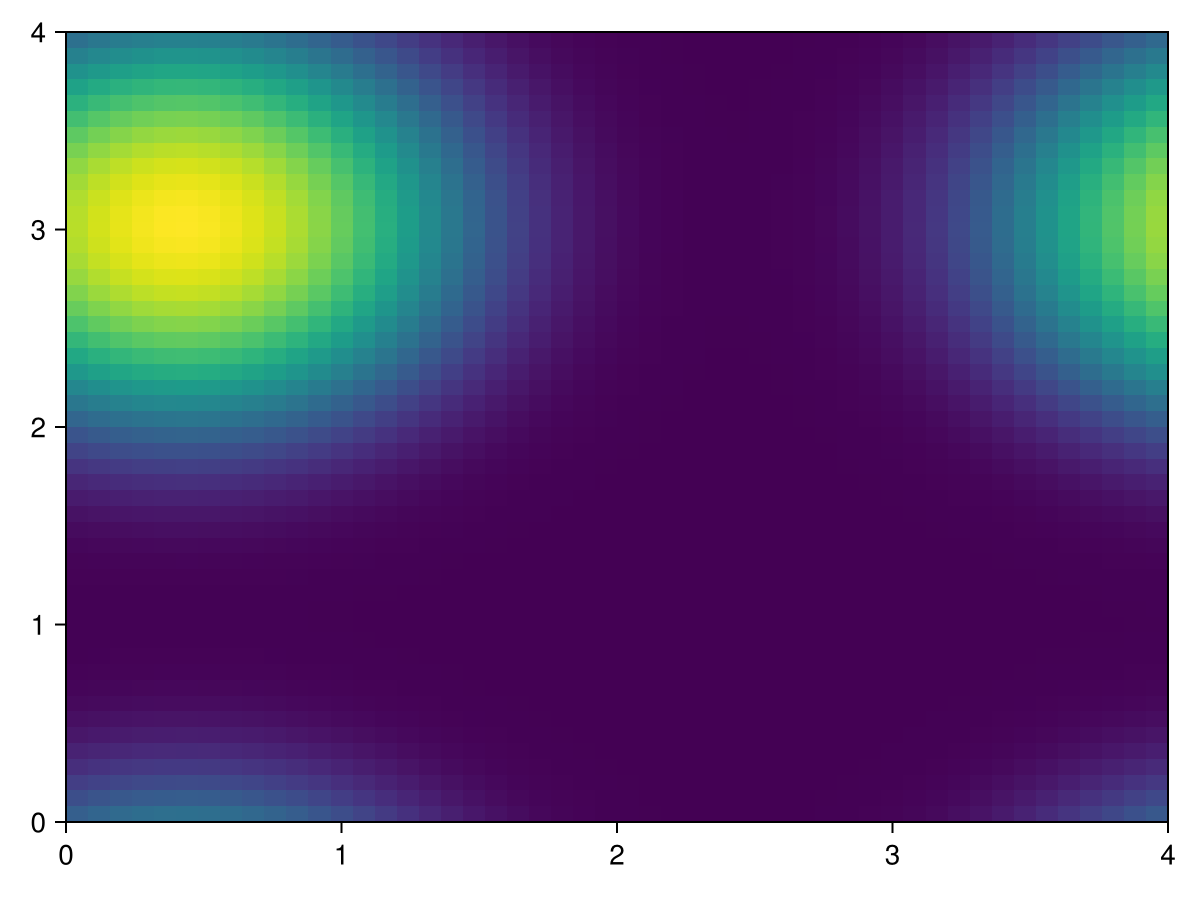

In [468]:
_size = size(sps.u[1][1,:,:])
dx = sps.prob.p.space.dx
heatmap(0:(_size[1]-1).*dx[1], 0:(_size[2]-1).*dx[2], sps.u[100][1,:,:])

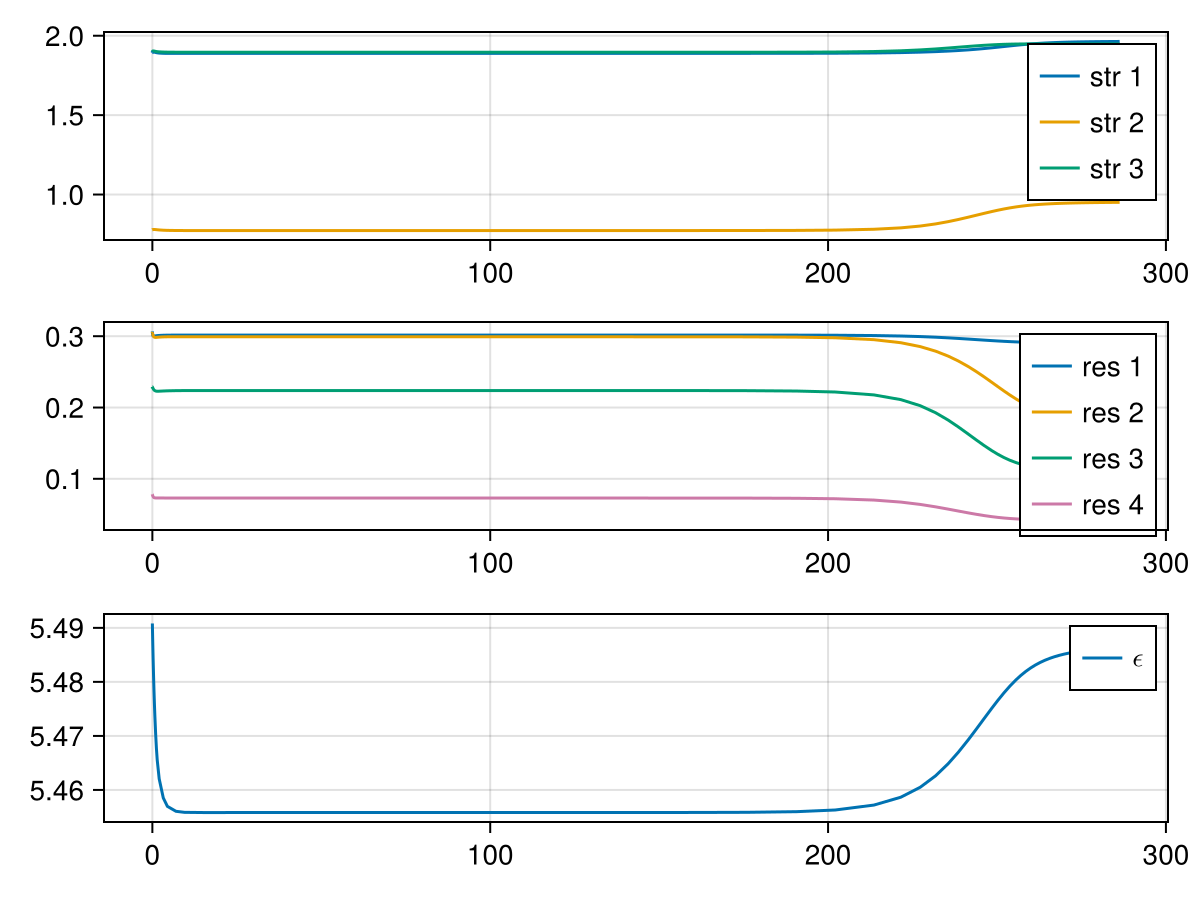

In [469]:
plot_smmicrm_sol_avgs(sps, 1:80; plote=true)

# Extras

In [263]:
GC.gc()
empty!(Out)

Dict{Int64, Any}()